# AI-Powered Sales Analysis & Forecasting for Business Growth

Olist was founded in 2015 and was relatively new business when they released their dataset on Kaggel. We have observations from Sept 2016 to Aug 2018. 
For a relatively new business it is very critical to understand how their business is growing and how they can be prepared to scale and maintain it further.

Keeping this in mind, we are trying to forecast the sales for Olist so that they can channelize their resources for stock preparation, marketing campaigns and get better prepared for future.

[1. Importing Libraries](#Importing_libraries) </br>
[2. Importing Data](#Importing_Data)</br>
$\;\;\;\;$    [2.1 Data dictionary](#Data_dictionary) </br>
$\;\;\;\;$    [2.2 Processing data for time series](#Processing_data_for_time_series) </br>
[3. Explorartory Data Analysis](#Explorartory_Data_Analysis)</br>
$\;\;\;\;$    [3.1 General exploration](#General_exploration) </br>
$\;\;\;\;$    [3.2 Decomposing time series](#Decomposing_time_series) </br>
$\;\;\;\;$    [3.3 Checking stationarity](#Checking_stationarity) </br>
[4. Preparation for Modeling](#Preparation_for_Modeling)</br>
$\;\;\;\;$    [4.1 Train and test split](#Train_test_split) </br>
$\;\;\;\;$    [4.2 Defining functions for plotting predictions and forecast](#plotting_func) </br>
$\;\;\;\;$    [4.3 Defining functions for evaluation](#evaluation_metrics) </br>
[5. Modelling (SARIMA)](#SARIMA) </br>
$\;\;\;\;$    [5.1 Plotting ACF and PACF plot](#ACF_PACF) </br>
$\;\;\;\;$    [5.2 Applying SARIMA model](#Baseline) </br>
$\;\;\;\;$    [5.3 Plotting predictions and evaluating SARIMA model](#plot) </br>
$\;\;\;\;$    [5.4 Adding Exogenous variable holiday for SARIMAX](#SARIMAX) </br>
$\;\;\;\;$    [5.5 Applying grid search on SARIMAX with exogenous variable](#Grid_search) </br>
$\;\;\;\;$    [5.6 Plotting predictions and evaluating SARIMAX model](#plot_sarimax) </br>
[6. Modelling (XG Boost Regression)](#xg_boost) </br>
$\;\;\;\;$    [6.1 Preparing data for XG Boost Regression](#xg_boost_prep) </br>
$\;\;\;\;$    [6.2 Baseline model on daily data and its performance](#xg_baseline) </br>
$\;\;\;\;$    [6.3 Tuning XG Boost and evaluating and its performance](#xg_tuned) </br>
[7. Modelling (LSTM)](#LSTM) </br>
$\;\;\;\;$    [7.1 Preparing data for LSTM](#lstm_prep) </br>
$\;\;\;\;$    [7.2 Baseline model on daily data and its performance](#lstm_baseline_eval) </br>

# 1. Importing Libraries

<a id="Importing_libraries"></a>

In [5]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style= 'darkgrid' )

#some built in functions
import itertools
from datetime import datetime, timedelta

import warnings
#to supress warning generated for fb prophet using .append method by default
# warnings.simplefilter(action='ignore', category=FutureWarning) 
#to suppress warnings in Sarima model
# warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

#importing high level interactive plotting libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# importing time series stats model
import statsmodels.api as sm
from statsmodels.api import tsa 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#importing Sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX

#sklearn library
from sklearn.preprocessing import MinMaxScaler

#importing XG Boost 
import xgboost as xgb
from xgboost import plot_importance, plot_tree

#importing LSTM libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [6]:
import statsmodels
print(statsmodels.__version__)


0.14.5


# 2. Importing Data

<a id="Importing_Data"></a>

In [7]:
import os
import pandas as pd

# Đường dẫn tới file
products_path = r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\olist_products_dataset.csv'
translations_path = r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\product_category_name_translation.csv'

# Kiểm tra file products
if os.path.exists(products_path):
    products = pd.read_csv(products_path)
    print("Đọc file products thành công!")
else:
    raise FileNotFoundError(f"File products không tồn tại: {products_path}")

# Kiểm tra file translations
if os.path.exists(translations_path):
    translations = pd.read_csv(translations_path)
    print("Đọc file translations thành công!")
else:
    raise FileNotFoundError(f"File translations không tồn tại: {translations_path}")

# Merge dữ liệu
master = products.merge(translations, on='product_category_name', how='left')
print("Merge dữ liệu thành công, kích thước master:", master.shape)


Đọc file products thành công!
Đọc file translations thành công!
Merge dữ liệu thành công, kích thước master: (32951, 10)


In [8]:
import pandas as pd

# Load các file
products = pd.read_csv(r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\olist_products_dataset.csv')
translations = pd.read_csv(r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\product_category_name_translation.csv')
orders = pd.read_csv(r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\olist_orders_dataset.csv')
customers = pd.read_csv(r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\olist_customers_dataset.csv')
order_items = pd.read_csv(r'D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\Data\olist_order_items_dataset.csv')

# Merge product với translation
products_master = products.merge(translations, on='product_category_name', how='left')

# Merge order_items với products
order_items_master = order_items.merge(products_master, on='product_id', how='left')

# Merge order_items_master với orders
order_orders_master = order_items_master.merge(orders, on='order_id', how='left')

# Merge với customers
master = order_orders_master.merge(customers, on='customer_id', how='left')

In [9]:
product_categories = master['product_category_name_english'].dropna().unique()
product_categories = sorted(product_categories)  
product_categories


['agro_industry_and_commerce',
 'air_conditioning',
 'art',
 'arts_and_craftmanship',
 'audio',
 'auto',
 'baby',
 'bed_bath_table',
 'books_general_interest',
 'books_imported',
 'books_technical',
 'cds_dvds_musicals',
 'christmas_supplies',
 'cine_photo',
 'computers',
 'computers_accessories',
 'consoles_games',
 'construction_tools_construction',
 'construction_tools_lights',
 'construction_tools_safety',
 'cool_stuff',
 'costruction_tools_garden',
 'costruction_tools_tools',
 'diapers_and_hygiene',
 'drinks',
 'dvds_blu_ray',
 'electronics',
 'fashio_female_clothing',
 'fashion_bags_accessories',
 'fashion_childrens_clothes',
 'fashion_male_clothing',
 'fashion_shoes',
 'fashion_sport',
 'fashion_underwear_beach',
 'fixed_telephony',
 'flowers',
 'food',
 'food_drink',
 'furniture_bedroom',
 'furniture_decor',
 'furniture_living_room',
 'furniture_mattress_and_upholstery',
 'garden_tools',
 'health_beauty',
 'home_appliances',
 'home_appliances_2',
 'home_comfort_2',
 'home_confo

In [10]:
master.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')  

In [11]:
product_categories = master['product_category_name_english'].dropna().unique()
product_categories = sorted(product_categories)


In [12]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name          111047 non-null  object 
 8   product_name_lenght            111047 non-null  float64
 9   product_description_lenght     111047 non-null  float64
 10  product_photos_qty             111047 non-null  float64
 11  product_weight_g               112632 non-null  float64
 12  product_length_cm             

In [13]:
if 'Unnamed: 0' in master.columns:
    master.drop(columns=['Unnamed: 0'], inplace=True)


In [14]:
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name          111047 non-null  object 
 8   product_name_lenght            111047 non-null  float64
 9   product_description_lenght     111047 non-null  float64
 10  product_photos_qty             111047 non-null  float64
 11  product_weight_g               112632 non-null  float64
 12  product_length_cm             

In [15]:
master.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [16]:
master.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english    1627
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_sta

In [17]:
master.duplicated().sum()

0

In [18]:
print(f" The number of unique orders : {master['order_id'].nunique()}")
print(f" The number of unique customers : {master['customer_unique_id'].nunique()}")
print(f" The total number of customer transactions specified by customer ids :  {master['customer_id'].nunique()}")
print(f" Overall {round((master['customer_unique_id'].nunique()/master['customer_id'].nunique())*100, 2)} % transcations \
are made by new customers and {round((1 -(master['customer_unique_id'].nunique()/master['customer_id'].nunique()))*100,2)} % \
are made by repeat customers.")
print(f" The number of unique sellers {master['seller_id'].nunique()}")
print(f" The number of unique products sold at Olist platform {master['product_id'].nunique()}")

 The number of unique orders : 98666
 The number of unique customers : 95420
 The total number of customer transactions specified by customer ids :  98666
 Overall 96.71 % transcations are made by new customers and 3.29 % are made by repeat customers.
 The number of unique sellers 3095
 The number of unique products sold at Olist platform 32951


## 2.1 Data dictionary

<a id="Data_dictionary"></a>

We have a total of 110013 rows of orders with 28 features, I am specifying all the high level details about the data which we extracted during data cleaning and wrangling. Each row in the table specifies a order with the product category bought, quantity of item purchased, unit price of the product and has details about purchase time, delivery details, review score and customer and seller information. 

- **order_id** : Specifies the unique order. We have 95832 unique orders. Of 110K rows an order_id can reappear in the  dataframe but it will have another product category and number of items bought in that category.                     
- **customer_id**: Specifies the customer id for the order. We have a customer ids associated with each order. There are a total of 95832 unique customer ids.   
- **order_purchase_timestamp** : The time stamp for the order. It includes date and time.       
- **order_estimated_delivery_date** : Estimated delivery date at the time of purchase.  
- **qty** : Number of items bought in a product category                           
- **product_id** : This specify the actual product in a product category. We have 32072 unique products within 74 overall product categories.                       
- **seller_id** : We have 2965 unique sellers.                        
- **shipping_limit_date** : This date informs seller of the shipping limit so they can dispatch the order at the earliest.   
- **price** : Unit price for each product.                          
- **freight_value** : The freight charges based on product weight and dimension. This value is for one item. If there are three items the total freight will be equal to three times the freight_value.                 
- **product_name_lenght** : Number of characters extracted from the product name.          
- **product_description_lenght** : Number of characters extracted from the product description.    
- **product_photos_qty** : Number of product published photos.             
- **product_weight_g** : Product weight measured in grams.               
- **product_length_cm** : Product length measured in centimeters.              
- **product_height_cm** : Product height measured in centimeters.              
- **product_width_cm** : Product width measured in centimeters.               
- **product_category_name_english** : English names of product categories.  
- **seller_city** : It is the city where seller is located.                    
- **seller_state** : It is the state where seller is located.                  
- **seller_lat** : It is the latitude of seller location.                     
- **seller_lng** : : It is the longitude of seller location.                     
- **customer_unique_id** : There are 92755 unique customers which make up 96.79 % of the total customers in database. Only 3.21% of the customers have made repeat purchase. It may be because the data we have is the initial data when Olist had just started its business and therefore we have all the new customers in the database.            
- **customer_city** : It is the city where customer is located.                  
- **customer_state** : It is the state where customer is located.                
- **customer_lat** : It is the latitude of customer location.
- **customer_lng** : It is the longitude of customer location.                  
- **review_score** : Reviews submitted by the customers range from 1-5.

**`Target Variable`** : **total_amount** : We have calculated this value after multiplying **qty** and **price**. This is the actual sales amount important for the business. We will be predicting sales amount to help business prepare for the the future. 

`Note`: We have not considered freight charges in the calculation of 'total_amount' beacuse we found that when olist started its business it was outsourcing the logistics to third party and therefore we want to give business insight of only the sales from the products sold at the Olist platform.

We also found that Olist had accquired PAX, its logistic partner later in the year 2020, check [here](https://www.bloomberglinea.com/english/olist-becomes-brazils-newest-unicorn-raises-186m/) here for more details.

## 2.2 Processing Data for Time Series

<a id="Processing_data_for_time_series"></a>

We have seen that the 'order_purchase_timestamp' has incorrect format. We will start with converting this column to date-time format and we will try to extract some features from dates for analysis

In [19]:
#Convert date columns which are in object format to datetime format
master['order_purchase_timestamp']=pd.to_datetime(master['order_purchase_timestamp'])

In [20]:
#converting date columns which are in object format to datetime format
master['purchase_year']=pd.to_datetime(master['order_purchase_timestamp']).dt.year
master['purchase_month'] = pd.to_datetime(master['order_purchase_timestamp']).dt.month
master['purchase_MMYYYY'] = pd.to_datetime(master['order_purchase_timestamp']).dt.strftime('%m-%Y')
master['purchase_week'] = pd.to_datetime(master['order_purchase_timestamp']).dt.isocalendar().week
master['purchase_dayofweek'] = pd.to_datetime(master['order_purchase_timestamp']).dt.weekday
master['purchase_dayofmonth'] = pd.to_datetime(master['order_purchase_timestamp']).dt.day

We will aggregate the total_amount by dates so that we can get a time series, meaning a dataframe with the **total_amount** column arranged in order as per dates. We will set the dates as index.

In [21]:
# total_amount = price + freight_value
master['total_amount'] = master['price'] + master['freight_value']


In [22]:
# Creating new DataFrame with daily frequency and number of orders
df_agg = master.groupby(pd.Grouper(key='order_purchase_timestamp', freq='D'))['total_amount'].sum().reset_index()
df_agg.set_index('order_purchase_timestamp', inplace=True)
df_agg.index.freq = 'D' # To keep pandas inference in check!

#reading top five rows
print(df_agg.head())

                          total_amount
order_purchase_timestamp              
2016-09-04                      136.23
2016-09-05                       75.06
2016-09-06                        0.00
2016-09-07                        0.00
2016-09-08                        0.00


In [23]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2016-09-04 to 2018-09-03
Freq: D
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_amount  730 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [24]:
df_agg

,total_amount
order_purchase_timestamp,
2016-09-04,136.23
2016-09-05,75.06
2016-09-06,0.00
2016-09-07,0.00
2016-09-08,0.00
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


# 3. Explorartory Data Analysis

<a id="Explorartory_Data_Analysis"></a>

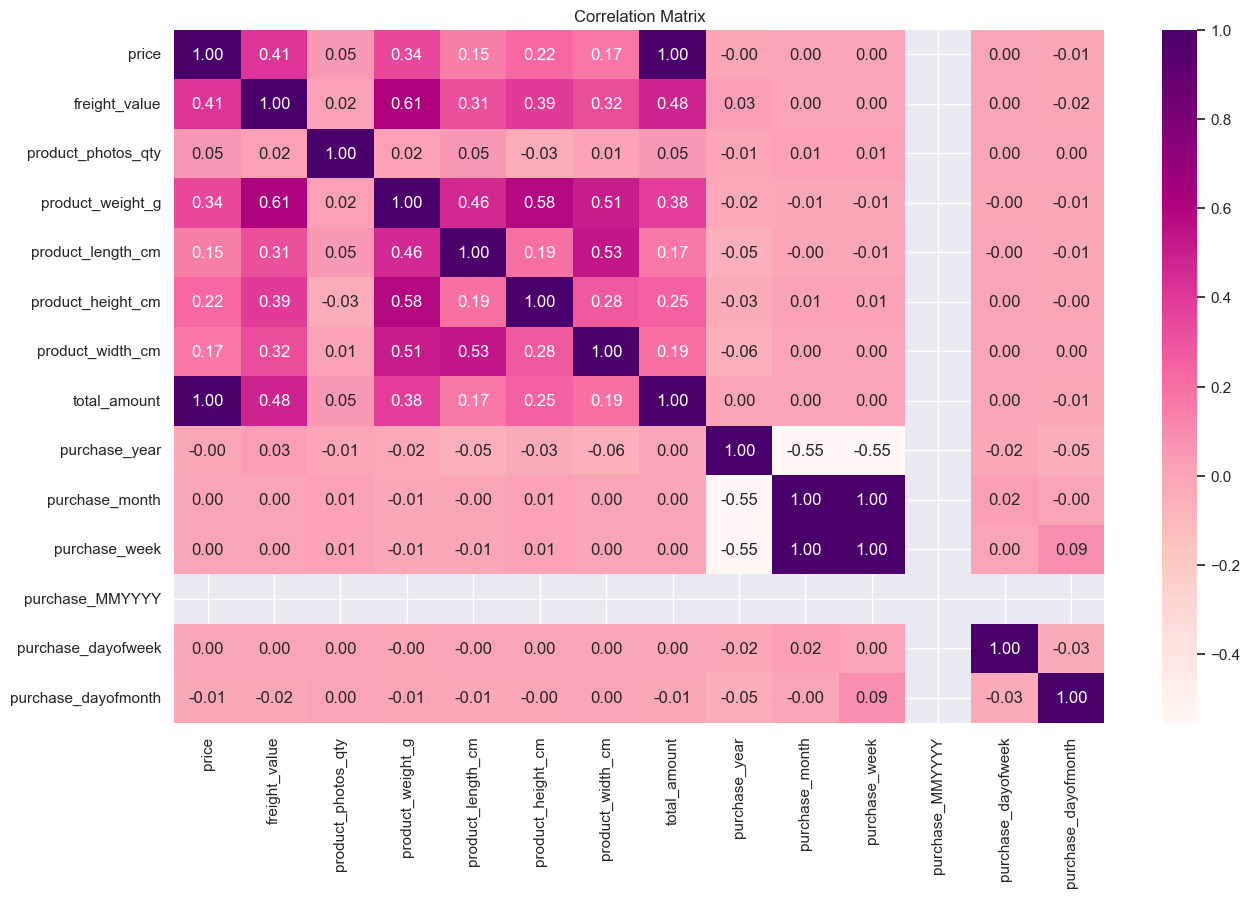

In [25]:
# Selecting relevant columns for correlation analysis
columns_for_correlation = ['price', 'freight_value', 
                           'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm',
                           'product_width_cm','total_amount','purchase_year','purchase_month',
                           'purchase_week','purchase_MMYYYY','purchase_dayofweek','purchase_dayofmonth',
                           ]

#product_name_length' , 'product_description_length',  'review_score', , 'qty''seller_lat',,'customer_lat'  ,'customer_lng''seller_lng'
master[columns_for_correlation] = master[columns_for_correlation].apply(pd.to_numeric, errors='coerce')

# Compute the correlation matrix
# Compute the correlation matrix
correlation_matrix = master[columns_for_correlation].corr()

import matplotlib.pyplot as plt
import seaborn as sns



# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(15,9))
sns.heatmap(correlation_matrix, annot=True, cmap='RdPu', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### Observation:

- We can see that **total_amount** is highly correlated with the price. This is obvious because we know that **total_amount** was caculated using price.
- **purchase_week** and **purchase_month**  are highly correlated.
- product_weight and freight values are positively correlated as frieght is calaculated as per product weight as it was specified by the data publishers on Kaggle.

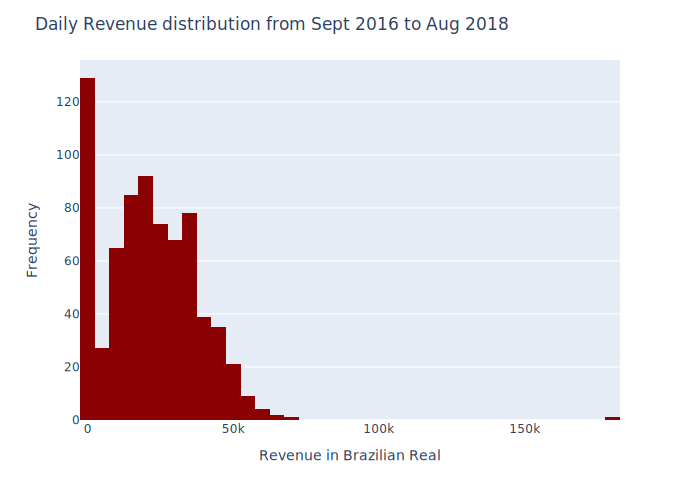

In [26]:
fig = px.histogram(df_agg, x='total_amount', color_discrete_sequence=['darkred'])

# Update the layout
fig.update_layout(
    yaxis_title="Frequency",
    xaxis_title="Revenue in Brazilian Real",
    legend_title="", 
    title="Daily Revenue distribution from Sept 2016 to Aug 2018"
)

# Show the plot as SVG
fig.show("svg")

#### Observations:

- There is a peak at zero amount because we dont have any observation for most of the days in 2016.
- If we ignore that, our overall distribution is normal with some outliers at the right side. Thse outliers obercations are from peak sales time.

In [27]:
print(master.columns)


Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'purchase_year', 'purchase_month', 'purchase_MMYYYY', 'purchase_week',
       'purchase_dayofweek', 'purchase_dayofmonth', 'total_amount'],
      dtype='object')


In [28]:
# check NaN
print(master[['purchase_year','purchase_month','purchase_MMYYYY','order_id','total_amount']].head(10))
print(master[['purchase_year','purchase_month','purchase_MMYYYY']].isna().sum())


   purchase_year  purchase_month  purchase_MMYYYY  \
0           2017               9              NaN   
1           2017               4              NaN   
2           2018               1              NaN   
3           2018               8              NaN   
4           2017               2              NaN   
5           2017               5              NaN   
6           2017              12              NaN   
7           2018               7              NaN   
8           2018               3              NaN   
9           2018               7              NaN   

                           order_id  total_amount  
0  00010242fe8c5a6d1ba2dd792cb16214         72.19  
1  00018f77f2f0320c557190d7a144bdd3        259.83  
2  000229ec398224ef6ca0657da4fc703e        216.87  
3  00024acbcdf0a6daa1e931b038114c75         25.78  
4  00042b26cf59d7ce69dfabb4e55b4fd9        218.04  
5  00048cc3ae777c65dbb7d2a0634bc1ea         34.59  
6  00054e8431b9d7675808bcb819fb4a32         31.75  


In [29]:
master['order_purchase_timestamp'] = pd.to_datetime(master['order_purchase_timestamp'])


In [30]:
master['purchase_year'] = master['order_purchase_timestamp'].dt.year
master['purchase_month'] = master['order_purchase_timestamp'].dt.month
master['purchase_MMYYYY'] = master['order_purchase_timestamp'].dt.strftime('%m-%Y')


In [31]:
print(master[['purchase_year','purchase_month','purchase_MMYYYY']].head(10))


   purchase_year  purchase_month purchase_MMYYYY
0           2017               9         09-2017
1           2017               4         04-2017
2           2018               1         01-2018
3           2018               8         08-2018
4           2017               2         02-2017
5           2017               5         05-2017
6           2017              12         12-2017
7           2018               7         07-2018
8           2018               3         03-2018
9           2018               7         07-2018


                                              order_id  total_amount
purchase_year purchase_month purchase_MMYYYY                        
2016          9              09-2016                 3        354.75
              10             10-2016               308      56808.84
              12             12-2016                 1         19.62
2017          1              01-2017               789     137188.49
              2              02-2017              1733     286280.62


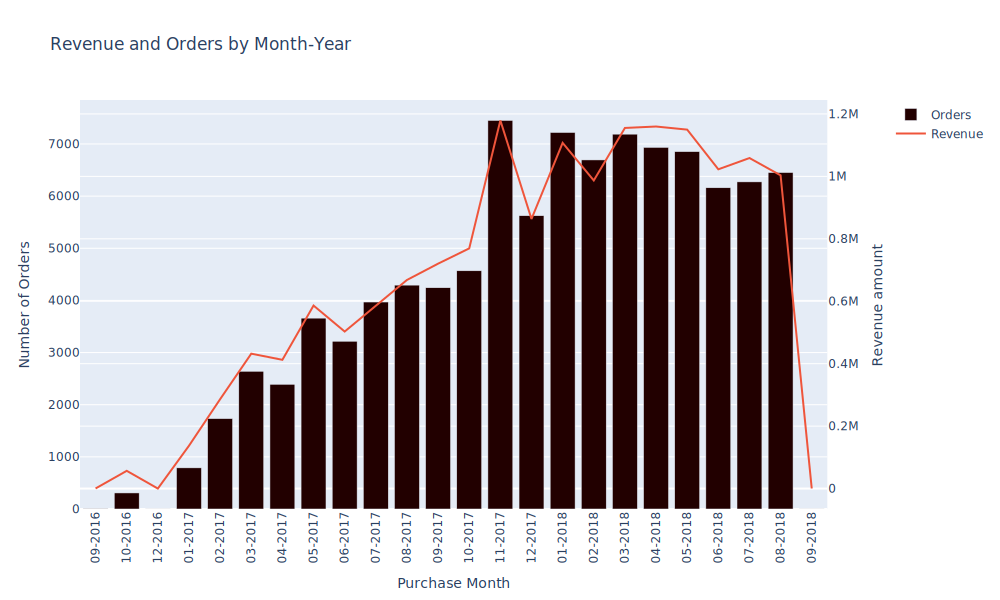

In [32]:
#we are creating pivot table with three index year, month and string MMYYY and getting sum of total_amount and number of orders
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sales_df=master.pivot_table(values=['order_id', 'total_amount']
                              , index=['purchase_year','purchase_month','purchase_MMYYYY']
                              , aggfunc={'order_id':'nunique', 'total_amount':'sum'})

from plotly.subplots import make_subplots
print(sales_df.head())
#to plot number of orders by MMYYY
trace1 = go.Bar(
    x=sales_df.index.get_level_values(2),
    y=sales_df['order_id'],
    name='Orders',
    marker=dict(
        color='rgb(34,0,0)'
               )
)
#to plot sum of total_amounts by MMYYY
trace2 = go.Scatter(
    x=sales_df.index.get_level_values(2),
    y=sales_df['total_amount'],
    name='Revenue',
    yaxis='y2' #using a right side y-axis

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update(height = 600, width = 1000, title = 'Revenue and Orders by Month-Year',xaxis=dict(
      tickangle=-90, title='Purchase Month'), yaxis=dict(title= 'Number of Orders'), yaxis2=dict(title= 'Revenue amount'))
# fig.show()
fig.show("svg")

We can see that both order made and total_amount are growing. There are some peaks that reappear after some month. The highes peak was recorded for Nov 2017.

In [33]:
print(f"The overall revenue earned as of August 2018 is {df_agg['total_amount'].sum()} Brazilian Real.")

The overall revenue earned as of August 2018 is 15843553.24 Brazilian Real.


We can check what is the overall revenue for each year and what is year over year growth from 2016 to 2017 and 2017 to 2018.

In [34]:
# Checking the sale made in each year
df_agg.groupby(df_agg.index.year).sum()

,total_amount
order_purchase_timestamp,
2016,57183.21
2017,7142672.43
2018,8643697.60


In [35]:
print(f'The year over year growth from 2017 to 2018 is {(8140605.72/6722987.98)-1}')

The year over year growth from 2017 to 2018 is 0.21086126350623036


In [36]:
#plotting daily data to get high level picture

fig = px.line(df_agg, x=df_agg.index, y='total_amount')

# Set line color to blue
fig.update_traces(line=dict(color='blue'))

# axis labels and title
fig.update_layout(
    yaxis_title="Total Revenue earned (Brazilian Real)", 
    legend_title="", 
    title="Daily Revenue from Sept 2016 to Aug 2018"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

#annotate peak
fig.add_annotation(x='2017-11-24', y= 184834.17, text=f'Black Friday Sale', yanchor='bottom', 
                   showarrow=True, arrowhead=1, arrowsize=1, arrowwidth=2, arrowcolor="#636363",
                   ax=-20, ay=-30, font=dict(size=15, color="red", family="Courier New, monospace"),
                   align="left", bordercolor="red", borderwidth=2, bgcolor="#CFECEC", opacity=0.8)

# fig.show()
fig.show("svg")


#### Observations:

- We can see that there is a positive trend.
- There is almost zero sales after October 10 2016 till Jan 2017.
- It looks like the business started rolling in from Jan 1 2017.
- There is a highest spike on Nov 24 2017 because it was black friday.
- There is another spike on Sept 29 2017.
- Seasonality is not clear at this point.

#### Removing the Observations before Jan 1 2017

- Removing the data before Jan 01 2017 because there are alot of consecutive days with zero sales. It may be because the period of Sept 2016 to Dec 2016 was an experimental phase. Including them in our model may impact our forecasting. We can find that we have continuous sales after Jan 2017.

In [37]:
# removing the rows before Jan 01 2017
daily_data = df_agg.loc[df_agg.index>='2017-01-01', :]

In [38]:
daily_data.head()

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27


In [39]:
daily_data

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [40]:
print(f"The total number of datapoint to work on :{daily_data.shape[0]}")

The total number of datapoint to work on :611


In [41]:
#saving the start and end dates separately
start_date=daily_data.index[0]
end_date=daily_data.index[-1]

In [42]:
start_date

Timestamp('2017-01-01 00:00:00')

In [43]:
end_date

Timestamp('2018-09-03 00:00:00')

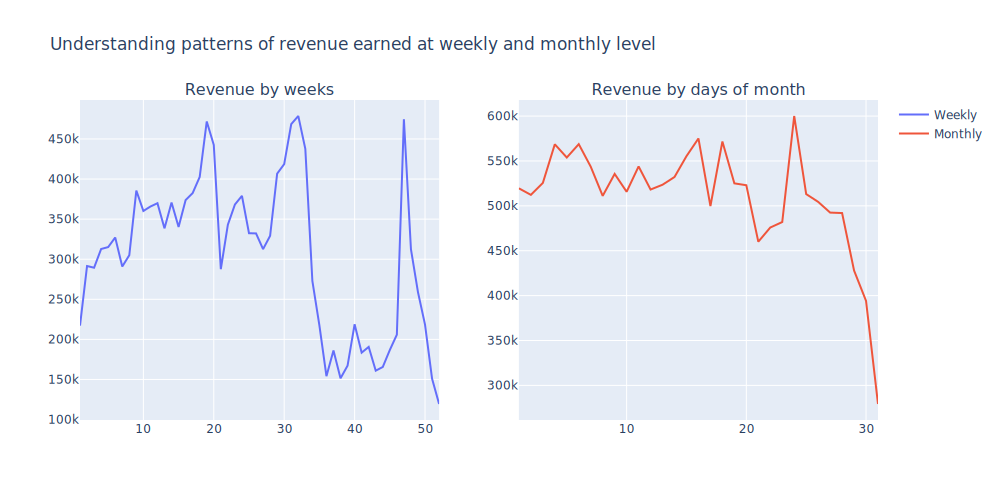

In [44]:
df1=master.groupby('purchase_week')['total_amount'].sum()
df2=master.groupby('purchase_dayofmonth')['total_amount'].sum()

fig=make_subplots(rows=1, cols=2, subplot_titles=("Revenue by weeks", "Revenue by days of month"))

fig.add_trace(go.Scatter(name='Weekly', x=df1.index, y=df1.values), row=1, col=1 )

fig.add_trace(go.Scatter(name='Monthly', x=df2.index, y=df2.values), row=1, col=2 )

fig.update_layout(height=500, width=1000,
                  title_text="Understanding patterns of revenue earned at weekly and monthly level")

# fig.show()
fig.show("svg")

Let us see which categories are highest earning categories.

In [45]:
# The categories that having the highest sales amount
df = master.groupby('product_category_name_english')['total_amount'].sum()


In [46]:
df.head()

product_category_name_english
agro_industry_and_commerce    78374.07
air_conditioning              61774.19
art                           28247.81
arts_and_craftmanship          2184.14
audio                         56398.94
Name: total_amount, dtype: float64

In [47]:
fig = px.bar(df, x= df.index,
            y=df.values,
            labels={'y':'Sales Amount'},
            title = 'Product Category by Sales Amount',
            width = 1500, height=1200)


In [48]:
fig

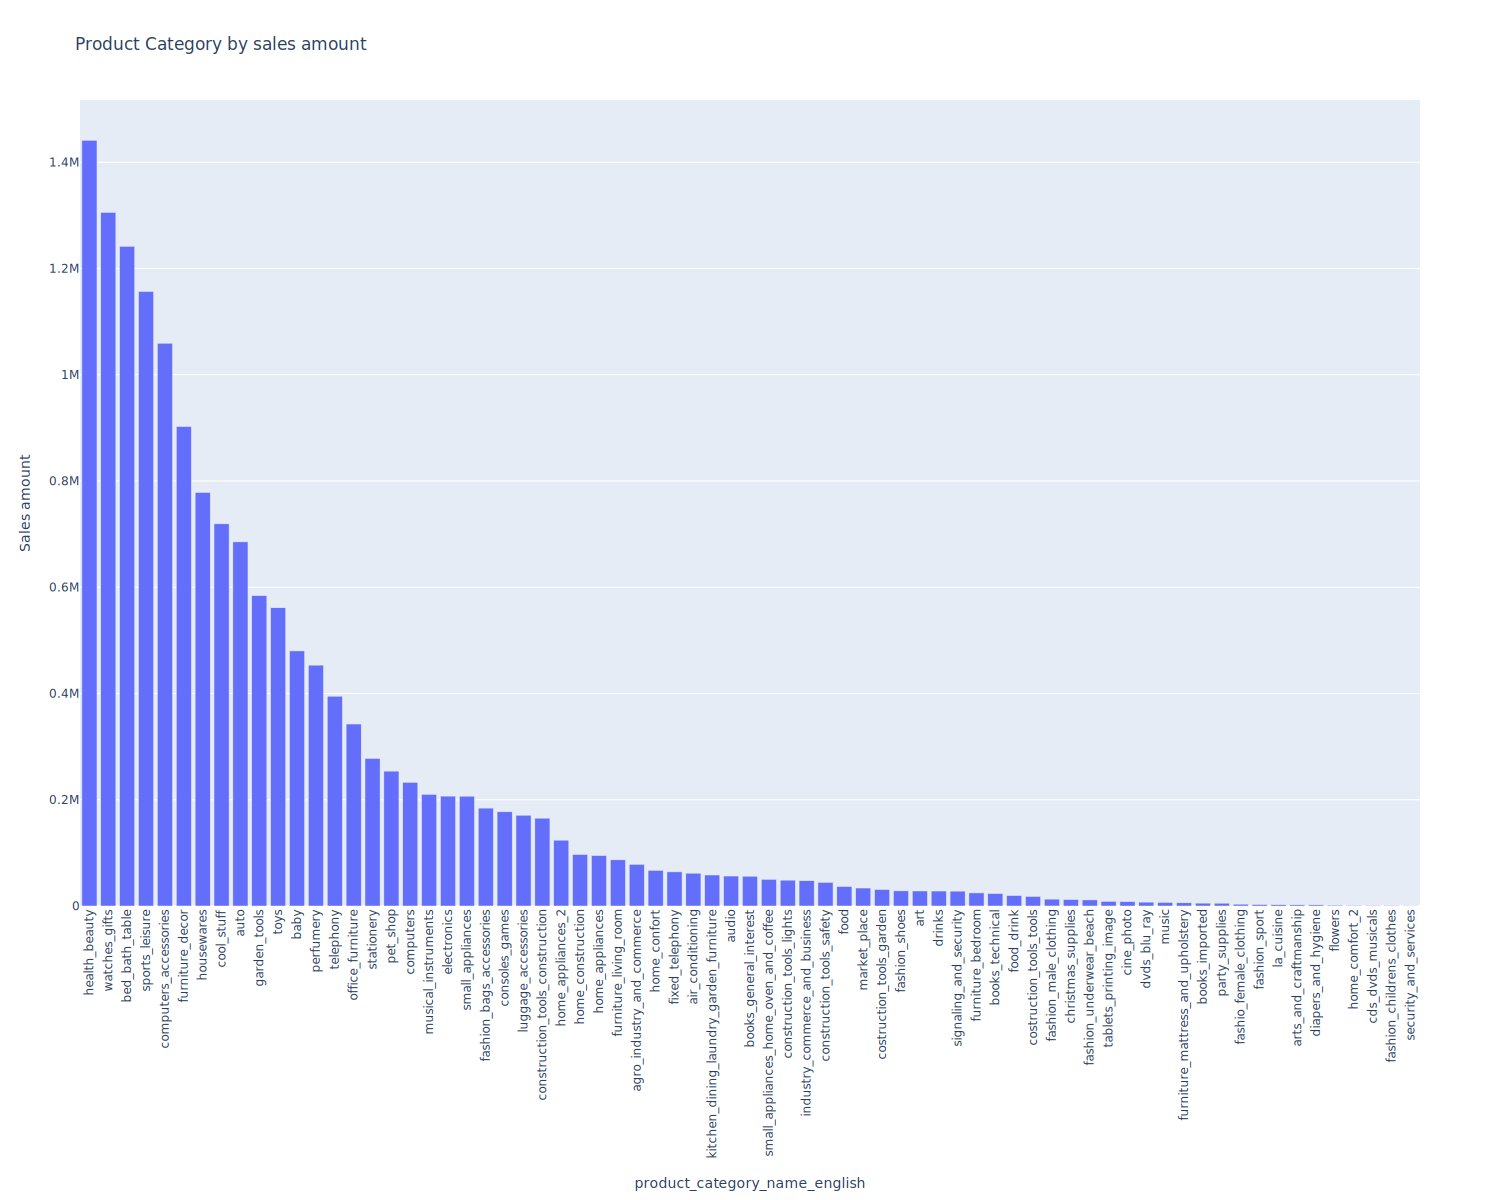

In [49]:
#the categories that are have highest sales amount
df=master.groupby('product_category_name_english')['total_amount'].sum().sort_values(ascending=False)
fig = px.bar(df, x= df.index,
             y=df.values,
             labels={'y':'Sales amount'},
             title='Product Category by sales amount',
             width=1500, height=1200)
fig.update_xaxes(tickangle= -90) 
# fig.show()
fig.show("svg")

#### Observations:

- **Health_beauty , watches_gift, bed_bath_table, computer_asscesories and sports_leisure** are the top category by sales amount.
- **PC_games, cds_dvds_musicals, fashion_children_clothes** are the lowest earning products categories.

## 3.2 Decomposing time series

<a id="Decomposing_time_series"></a>

**We will be decomposing the time series using additive decomposition so that we can observe the underlying trend, seasonality and residuals**. 

Additive Decomposition : $Trend$+$Seasonality$+$Residual$

In [50]:
# Decompose the time series
decomposition = tsa.seasonal_decompose(daily_data, model='addictive')

In [51]:
# Saving copy to new dataframe
daily_df = daily_data.copy()

In [52]:
daily_df

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [53]:
# Add the decomposition data
daily_df['Trend'] = decomposition.trend
daily_df['Seasonal'] = decomposition.seasonal
daily_df['Residual'] = decomposition.resid

In [54]:
daily_df['Trend'].isnull().sum()
#daily_df['Seasonal'] = decomposition.seasonal
#daily_df['Residual']

6

In [55]:
daily_df['Seasonal']

order_purchase_timestamp
2017-01-01   -4656.913628
2017-01-02    3959.957169
2017-01-03    3097.980923
2017-01-04    2325.202549
2017-01-05    1006.505078
                 ...     
2018-08-30    1006.505078
2018-08-31     218.483698
2018-09-01   -5951.215788
2018-09-02   -4656.913628
2018-09-03    3959.957169
Freq: D, Name: Seasonal, Length: 611, dtype: float64

In [56]:
daily_df['Residual'].isnull().sum()

6

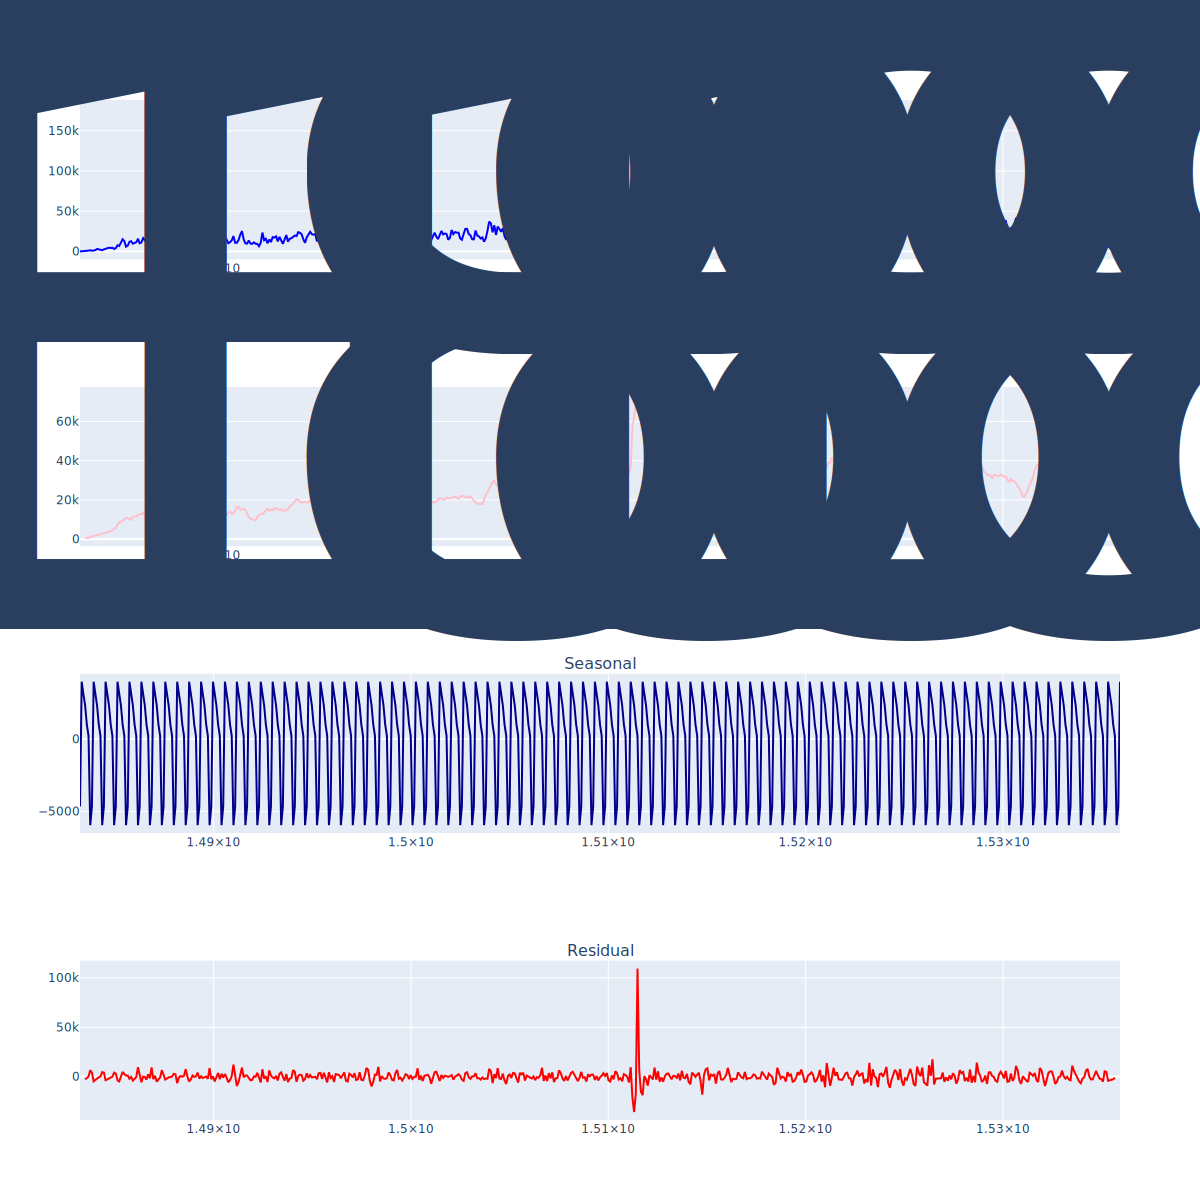

In [57]:
# Plotting the actual and decomposed components of time series
cols = ["total_amount", "Trend", "Seasonal", "Residual"]
colors = ["blue", "pink", "darkblue", "red"]

fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

for i, (col, color) in enumerate(zip(cols, colors)):
    fig.add_trace(
        go.Scatter(x=daily_df.index, y=daily_df[col], line=dict(color=color)),
        row=i + 1,
        col=1
    )

fig.update_layout(height=1200, width=1200, showlegend=False)
fig.show("svg")


#### Observations:

- **Trend** We can see that there is a slightly upward trend. Trend has a peak on Nov 26, 2017 because of the black friday sale on Nov 24, 2017. It falls afterwards but then rises again. Even if the black friday is outlier but we should consider it in our calculation as it is an important factor.
- **Seasonality** there is a weekly seasonality. It peaks once in the week and then falls and so on.
- **Residual** It captured the peaks of Nov 24, 2017 and Sept 29, 2017.

<Axes: title={'center': 'Pattern of revenue earned at week level'}, xlabel='Weekday', ylabel='total_amount'>

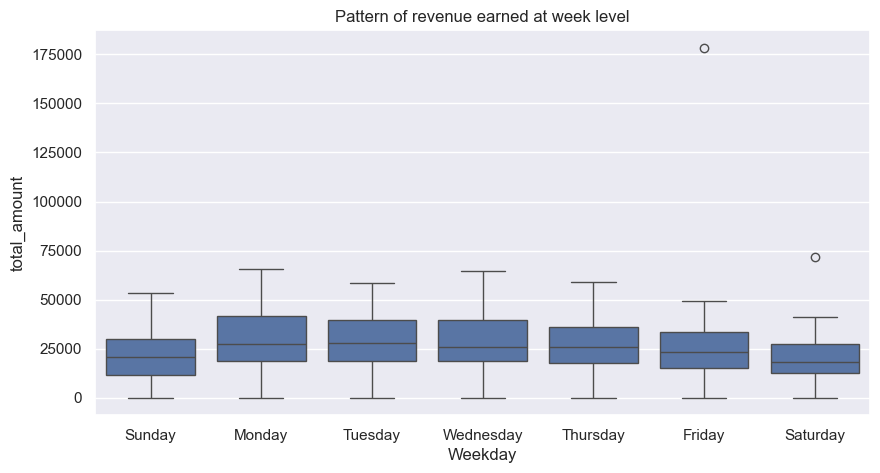

In [58]:
plt.subplots(figsize=(10,5))
plt.title('Pattern of revenue earned at week level')
df_week_check=daily_data.copy()
df_week_check['Weekday']= df_week_check.index.weekday
week_day=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_week_check['Weekday']=df_week_check['Weekday'].apply(lambda x: week_day[x])          
sns.boxplot(data=df_week_check, x='Weekday', y='total_amount')

#### Observations:
- We can see that the amount earned is high on monday and tuesday. It decreases toward the end of the week.
- There are some outliers on Friday and Saturday because if the holidays.

Next, We will proceed ahead with checking stationarity of the time series so that we can apply Modelling.

## 3.3 Checking stationarity

<a id="Checking_stationarity"></a>

Forecasting is built on assumption that historical data is representative of the future. It is important for a time series to be stationary, If it is not, it means that the data **changes** over time and it will be hard to forecast that data.

If the mean and variance of the time series are constant that means the time series is stationary. We will plot the rolling mean and rolling standard deviation for the time series to visually check for stationarity.

- A rolling average can help you find trends that would otherwise be hard to detect.
- Voltality is based on standard deviation, a measure of how much the data varies from the average or the measure of spread.

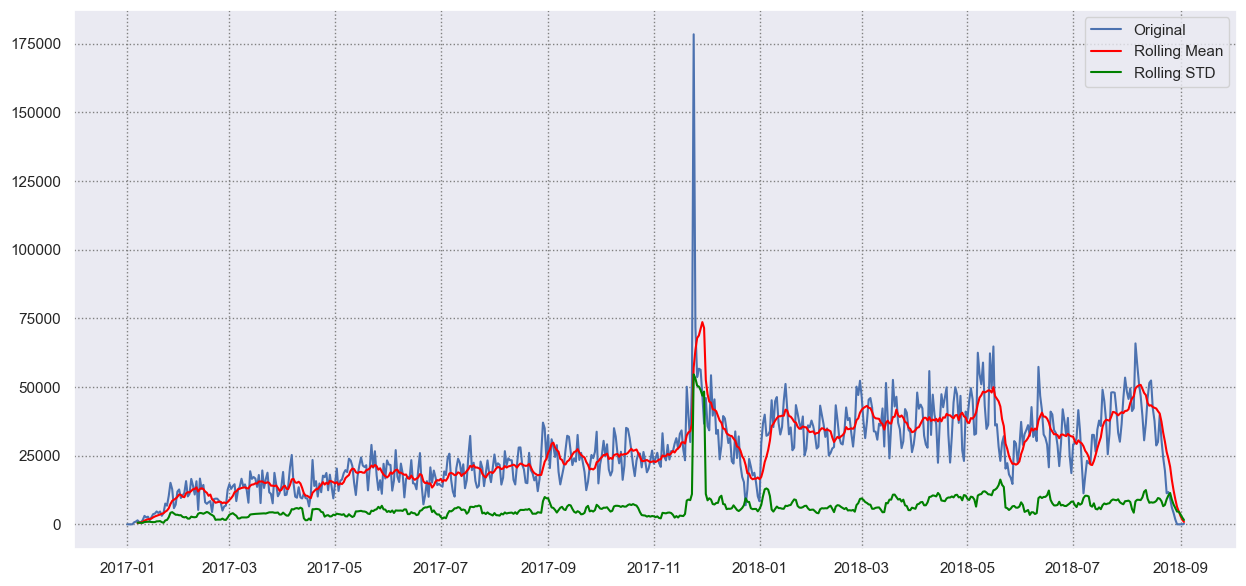

In [59]:
# Plotting rolling mean and standard deviation.

# Get things rolling
roll_mean = daily_df['total_amount'].rolling(window=7).mean()
roll_std = daily_df['total_amount'].rolling(window=7).std()

# Figure
fig, ax = plt.subplots(figsize=(15,7), facecolor='w')
ax.plot(daily_df['total_amount'], label='Original')
ax.plot(roll_mean, label='Rolling Mean', color='red')
ax.plot(roll_std, label='Rolling STD', color='green')

# Legend & Grid
ax.legend(loc='upper right')
plt.grid(linestyle=":", color='grey')
plt.show()

#### Observations:

- The mean is not constant. As we progress on time series the rolling mean is having somewhat upward trend.
- There rolling mean rises and falls within two month period.
- Rolling standard deviation also doesn't look constant.

Therefore, We can say that the trend is not **Stationary**.

## Statistical tests to check stationarity

### ADF - Augmented Dickey Fuller Test

ADF test is used to determine the presence of unit root in the series, the presence of a unit root means the time series is **non-stationary**. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. The null and alternate hypothesis of this test are:

$H_0$ : The series has a unit root. 

$H_a$: The series has no unit root.

If the null hypothesis is failed to be rejected (the p-value obtained is greater than the significance level (say 0.05)), this test may provide evidence that the series is non-stationary.


### KPSS - Kwiatkowski-Phillips-Schmidt-Shin

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_0$ : The process is trend stationary.

$H_a$: The series has a unit root (series is not stationary).

There are several methods to check for stationarity in time series data besides the Augmented Dickey-Fuller (ADF) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests. These methods help assess whether a time series is stationary, meaning its statistical properties do not change over time. Here are some additional methods:

Visual Inspection: Plot the time series data and look for any obvious trends or seasonality. A stationary series should have constant mean and variance over time.

Summary Statistics: Calculate the mean and variance of the time series over different time periods (e.g., rolling windows) and see if they remain relatively constant.

Differencing: Take first or higher-order differences of the time series data and see if the resulting series becomes stationary. This is often done by subtracting the previous observation from the current one.

ACF and PACF Plots: Examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the differenced series. In a stationary series, the ACF and PACF should decay rapidly to zero.

Ljung-Box Test: This test assesses the autocorrelation of a time series at different lags. If the p-values from the Ljung-Box test are below a significance level, it suggests that the series may not be stationary.

Phillips-Perron Test: Similar to the ADF test, the Phillips-Perron test is used to test for unit roots in a time series. It is another way to check for stationarity.

Seasonal Decomposition: Decompose the time series into its trend, seasonal, and residual components using methods like Seasonal Decomposition of Time Series (STL) or seasonal decomposition of time series (SARIMA modeling). A stationary residual component is a good sign of stationarity.

Augmented Engle-Granger Test: This test is used to check for cointegration between two time series. If the series are cointegrated, they must be individually stationary.

Rolling Statistics: Calculate rolling statistics such as rolling mean and rolling variance and check if they remain constant over time.

Hurst Exponent: The Hurst exponent measures the long-term memory of a time series. A Hurst exponent less than 0.5 indicates a stationary or mean-reverting series.

Variance Ratio Test: This test compares the variances of subseries within the original series to assess stationarity.

Jarque-Bera Test: It is a test for normality of the time series. A non-normal distribution could indicate non-stationarity.

#### ADF and KPSS test on original Sales amount

ADF and KPSS test on original total_amount

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -3.157070
p-value: 0.022608
Number of lags used: 15
Number of observations used: 595
T values corresponding to adfuller test:
1% -3.441388211993052
5% -2.8664097967491498
10% -2.569363480686392


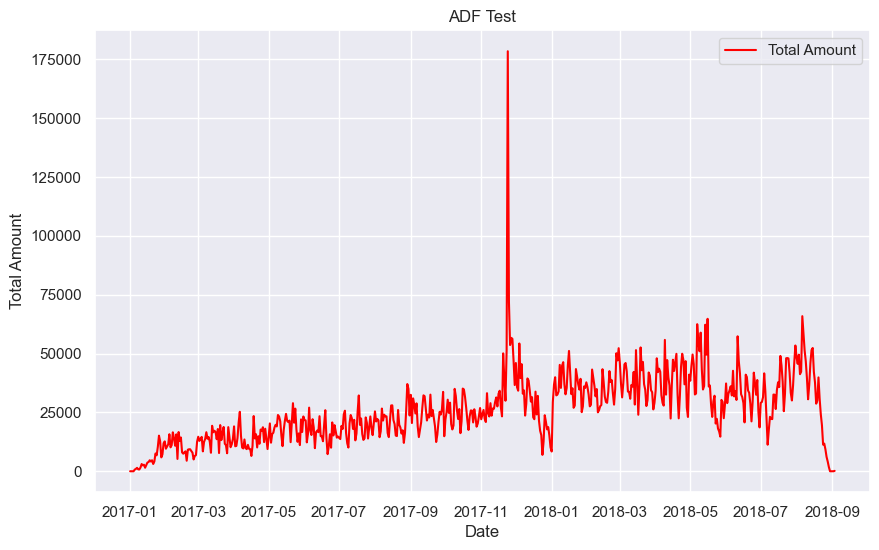


Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 2.520503
p-value: 0.010000
Number of lags used: 15
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


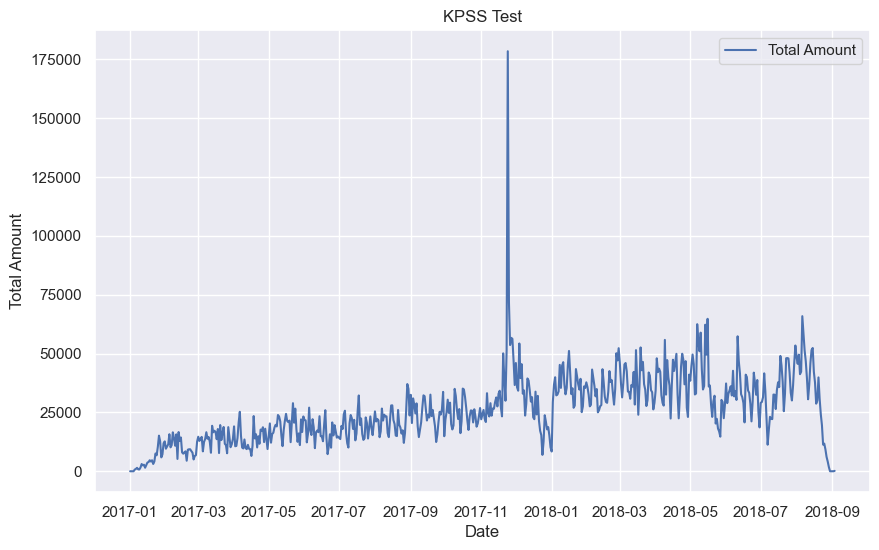

In [60]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)
    
    # Plot ADF test results
    plt.figure(figsize=(10, 6))
    plt.plot(df, label='Total Amount', color='red')
    plt.title('ADF Test')
    plt.xlabel('Date')
    plt.ylabel('Total Amount')
    plt.legend(loc='best')
    plt.show()


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)
    
     # Plot KPSS test results
    plt.figure(figsize=(10, 6))
    plt.plot(df, label='Total Amount')
    plt.title('KPSS Test')
    plt.xlabel('Date')
    plt.ylabel('Total Amount')
    plt.legend(loc='best')
    plt.show()

# Call the functions with 'total_amount' column
print("ADF and KPSS test on original total_amount")
perform_adf_test(daily_df['total_amount'])
perform_kpss_test(daily_df['total_amount'])

#### Observation and findings:

*ADF & KPSS Results on Original sales data*
- Since ADF Statistic  p-value: 0.006249 < 0.05 we can reject the $H_{0}$ hypothesis in the favor of $H_{a}$
- Since KPSS Statistic p_value: 0.01 < 0.05 we can reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have no unit root.** Thereby, inferring that the series is stationary.
- According to KPSS test our series is not trend-stationary.

Taking refrence from [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#Detrending-by-Differencing) which says if :  
**KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.**

We will proceed ahead with differencing the time series and recheck for stationarity.

#### Differencing the time series

We will try to difference the series by differencing it with a previous day observation. 

In [61]:
daily_df.head()

,total_amount,Trend,Seasonal,Residual
order_purchase_timestamp,,,,
2017-01-01,0.00,NaN,-4656.913628,NaN
2017-01-02,0.00,NaN,3959.957169,NaN
2017-01-03,0.00,NaN,3097.980923,NaN
2017-01-04,0.00,449.077143,2325.202549,-2774.279692
2017-01-05,707.27,564.738571,1006.505078,-863.973649


In [62]:
# Differencing with previous day
daily_df["day_difference"] = daily_df["total_amount"].diff(1)

In [63]:
daily_df["day_difference"]

order_purchase_timestamp
2017-01-01        NaN
2017-01-02       0.00
2017-01-03       0.00
2017-01-04       0.00
2017-01-05     707.27
               ...   
2018-08-30   -1762.70
2018-08-31       0.00
2018-09-01       0.00
2018-09-02       0.00
2018-09-03     166.46
Freq: D, Name: day_difference, Length: 611, dtype: float64

 ADF and KPSS Test on differenced data 

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -7.179660
p-value: 0.000000
Number of lags used: 19
Number of observations used: 590
T values corresponding to adfuller test:
1% -3.4414821678603946
5% -2.8664511716874657
10% -2.5693855271473716


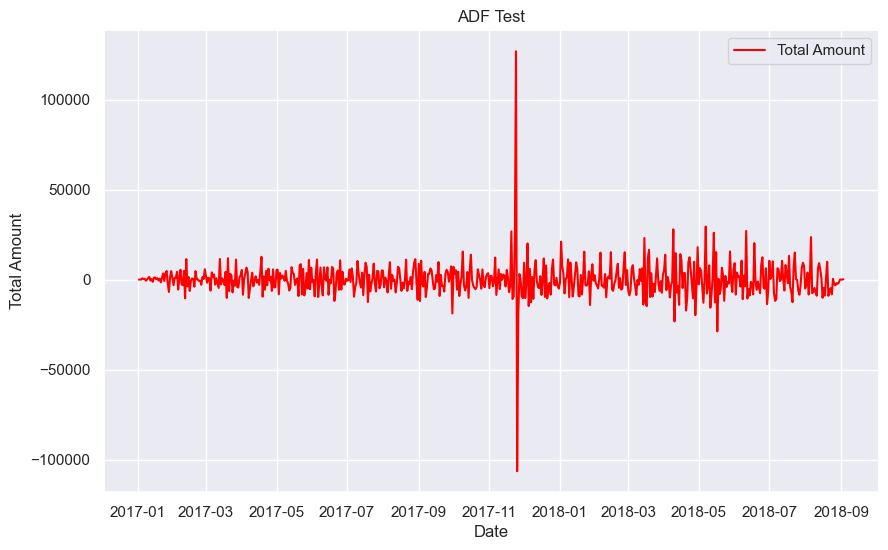


Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.164875
p-value: 0.100000
Number of lags used: 35
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


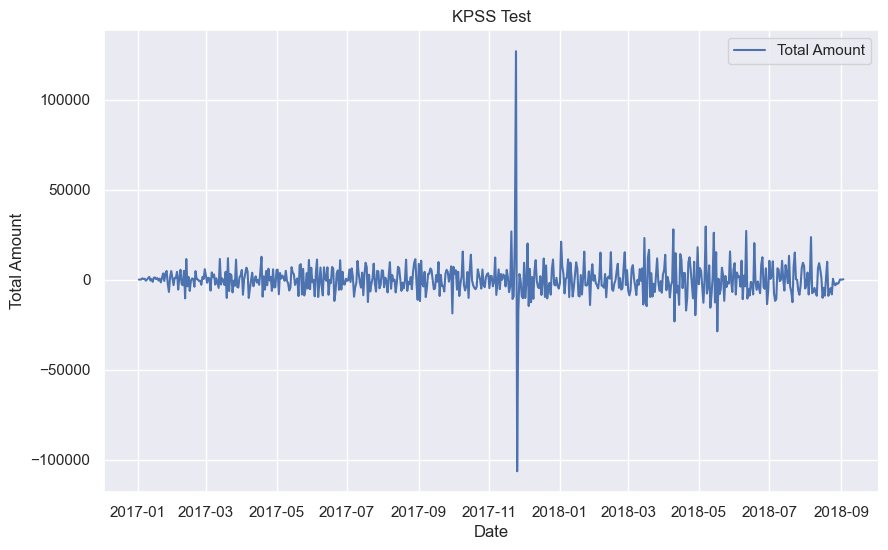

In [64]:
print(" ADF and KPSS Test on differenced data ")
perform_adf_test(daily_df["day_difference"].dropna())
perform_kpss_test(daily_df["day_difference"].dropna())

#### Observations and findings:

*ADF & KPSS Results on differenced data*

- Since ADF Statistic  p-value: 0.000 < 0.05 we can reject the $H_{0}$ hypothesis in the favor of $H_{a}$
- Since KPSS Statistic p_value: 0.1 > 0.05 we cannot reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have no unit root.** Thereby, inferring that the series is **stationary**.
- According to KPSS test our series is not trend-stationary.

**Both tests conclude that - The series is stationary.**

We can proceed ahead with modelling.

# 4. Preparation for Modeling

<a id="Preparation_for_Modeling"></a>

We want to create some functions that we will call again and again. Hence we will be creating a test and tarin split 

## 4.1 Train and test split

<a id="Train_test_split"></a>

We will be splitting the series into train and test. We will not be splitting the train for a validation set as we have a limited number of data.

In [65]:
def train_test_split(df, train_end, test_set):
    """
    Splits input dataframe into test and train set with 80% / 20%.
    ---
    Args:
        df : dataframe to split with datetime index.
        train_end: end date of the train set (inclusive), it can be a datetime or string of format YYYY-MM-DD.
        test_end: end date of the test set

    Returns:
        train_df (pd.DataFrame): Train Dataframe
        test_df (pd.DataFrame):  Test Dataframe
    """
    train_set = df[df.index <= train_end]
    test_set = df[df.index > train_end]
    return train_set, test_set


train_end = '2018-4-30'
test_end = '2018-8-29'

train_df, test_df = train_test_split(daily_data, train_end, test_end)

In [66]:
print(f'The Train data has time range :Shape {train_df.shape} | {train_df.index[0]} to {train_df.index[-1]}')
print(f'The Test data has time range :Shape {test_df.shape} | {test_df.index[0]} to {test_df.index[-1]}' )

The Train data has time range :Shape (485, 1) | 2017-01-01 00:00:00 to 2018-04-30 00:00:00
The Test data has time range :Shape (126, 1) | 2018-05-01 00:00:00 to 2018-09-03 00:00:00


## 4.2 Defining functions for plotting predictions and forecast

<a id="plotting_func"></a>

In [67]:
def plot_forecast(train_set, test_set, fc_series:pd.Series) -> None:
    """
    This function plots the train, test and forecast values.
    ---
    Args:
        train_df:  training dataframe with datetime index and only one column y
        test_df :  test dataframe with datetime index and only one column y
        fc_series: forecast series 
        
    Returns: None
    """
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_set.index, y=train_set.values, mode='lines', name="Train"))
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test"))
    fig.add_trace(go.Scatter(x=fc_series.index, y=fc_series.values, mode='lines', name="Forecast", line=(dict(color='black'))))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount", 
        xaxis_title="Date",
        title="Daily Sales amount and forecast"
    )
#     fig.show()
    fig.show("svg")


In [68]:
def plot_test_predictions(test_set, predictions) -> None:
    """
    This functions plots test set vs predicted values.
    ---
    Args:
        test_df : test dataframe with datetime index and only one column y
        predictions (predictions): prediction values (array or list)
    
    Returns: None
    """
    test_set=pd.Series(test_set, index= test_set.index)
    predictions=pd.Series(predictions, index= test_set.index)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_set.index, y=test_set.values, mode='lines', name="Test",line=dict(color='red')))
    fig.add_trace(go.Scatter(x=predictions.index, y=predictions.values, mode='lines', name="Predictions", line=dict(color='blue')))

    fig.update_xaxes(rangeslider_visible=True)
    fig.update_layout(
        yaxis_title="Revenue amount for test and predicted values", 
        xaxis_title="Date",
        title="Daily revenue amount"
    )
#     fig.show()
    fig.show("svg")


## 4.3 Defining functions for evaluation

<a id="evaluation_metrics"></a>

In [69]:
def mape_metrics(test_set, predicted) -> float:
    """
    This function calculates the MAPE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float MAPE percentage
    """
    # Calculate the MAPE value and return
    mape_result=round(np.mean(np.abs((test_set - predicted) / test_set)) * 100, 2)
    return mape_result

def rmse_metrics(test_set, predicted) -> float:
    """
    This function calculates the RMSE.
    ---
    Args:
        test_set (pd.Series):  test set filtered series with y
        predicted (pd.Series):  predicted series
        
    Returns: float RMSE
    """  
    # Calculate the MAPE value and return
    return round(np.sqrt(np.mean((test_set - predicted)**2)),2)

# 5. Modelling (SARIMA)

<a id="SARIMA"></a>

We will start with SARIMA model to account for the seasonality in our model. SARIMA is Seasonal Autoregressive Integrated Moving Average, which explicitly supports univariate time series data with a seasonal component. Before jumping on to modelling, we need to get a basic understanding of what orders for Auto gregressive and Moving average to choose. We will plot the ACF and PACF plots to find it out.

**ACF** : Auto correlation function, describes correlation between original and lagged series. **Purpose**: The ACF plot is used to measure how much current values in the time series are correlated with past values. This is useful for identifying patterns such as seasonality or trends.

**PACF** : Partial correlation function is same as ACF but it removes all intermediary effects of shorter lags, leaving only the direct effect visible. **Purpose**: The PACF plot is similar to the ACF plot but shows the correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. This can be helpful in identifying the order of an autoregressive model.

In [70]:
def plot_acf_pacf(df, acf_lags: int, pacf_lags: int) -> None:
    """
    This function plots the Autocorrelation and Partial Autocorrelation lags.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the order count and dates.
        acf_lags (int): Number of ACF lags
        pacf_lags (int): Number of PACF lags
    Returns: None
    """
    
    # Figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9), facecolor='w')
    
    # ACF & PACF
    plot_acf(df, ax=ax1, lags=acf_lags)
    plot_pacf(df, ax=ax2, lags=pacf_lags, method='ywm')

    # Labels
    ax1.set_title(f"Autocorrelation {df.name}", fontsize=15, pad=10)
    ax1.set_ylabel("Sales amount", fontsize=12)
    ax1.set_xlabel("Lags (Days)", fontsize=12)

    ax2.set_title(f"Partial Autocorrelation {df.name}", fontsize=15, pad=10)
    ax2.set_ylabel("Sales amount", fontsize=12)
    ax2.set_xlabel("Lags (Days)", fontsize=12)
    
    # Legend & Grid
    ax1.grid(linestyle=":", color='grey')
    ax2.grid(linestyle=":", color='grey')

    plt.show()

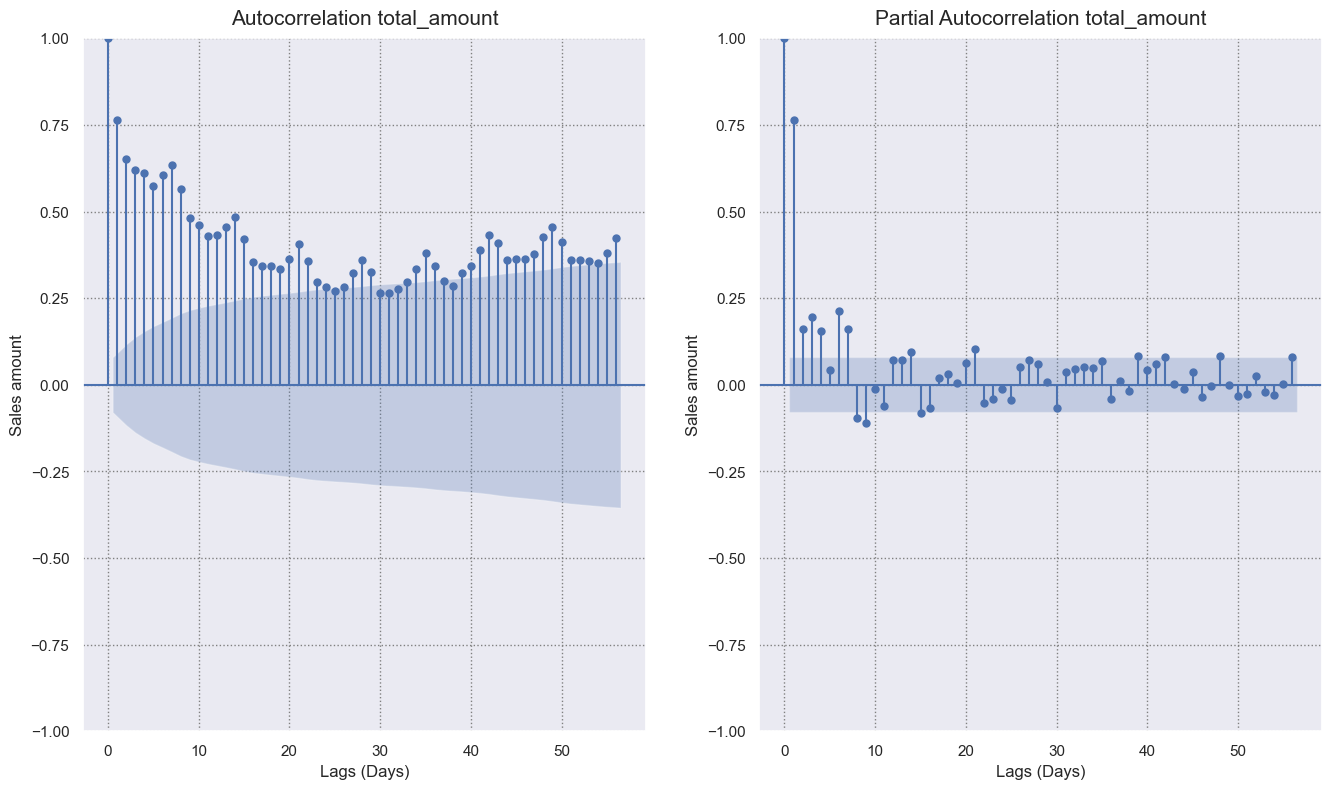

In [71]:
#plotting the ACF and PACF plot for original series
plot_acf_pacf(daily_df['total_amount'], acf_lags=56, pacf_lags=56)

#### Observations:
ACF Plot: 

- The **ACF** plot shows a gradual decline rather than a sharp drop-off after a few lags. This behavior often suggests that the series is not stationary because the correlations decay slowly rather than abruptly.
- In the **ACF** plot, the slowly decreasing bars suggest a gradual decline in correlation as the days increase, which might indicate a long-term trend in the time series.

PACF Plot:

- In the **PACF** plot, there is a significant spike at lag 1, and the rest of the spikes are mostly within the confidence interval, which may suggest an AR(1) model could be suitable for this data. it is not sufficient alone to determine stationarity.

We will try to plot the ACF and PACF plot by double differncing means differencing the day_difference with seasonal differnce data.

In [72]:
#double differencing the column total_amount
daily_df['second_difference'] = daily_df['day_difference'].diff(2)

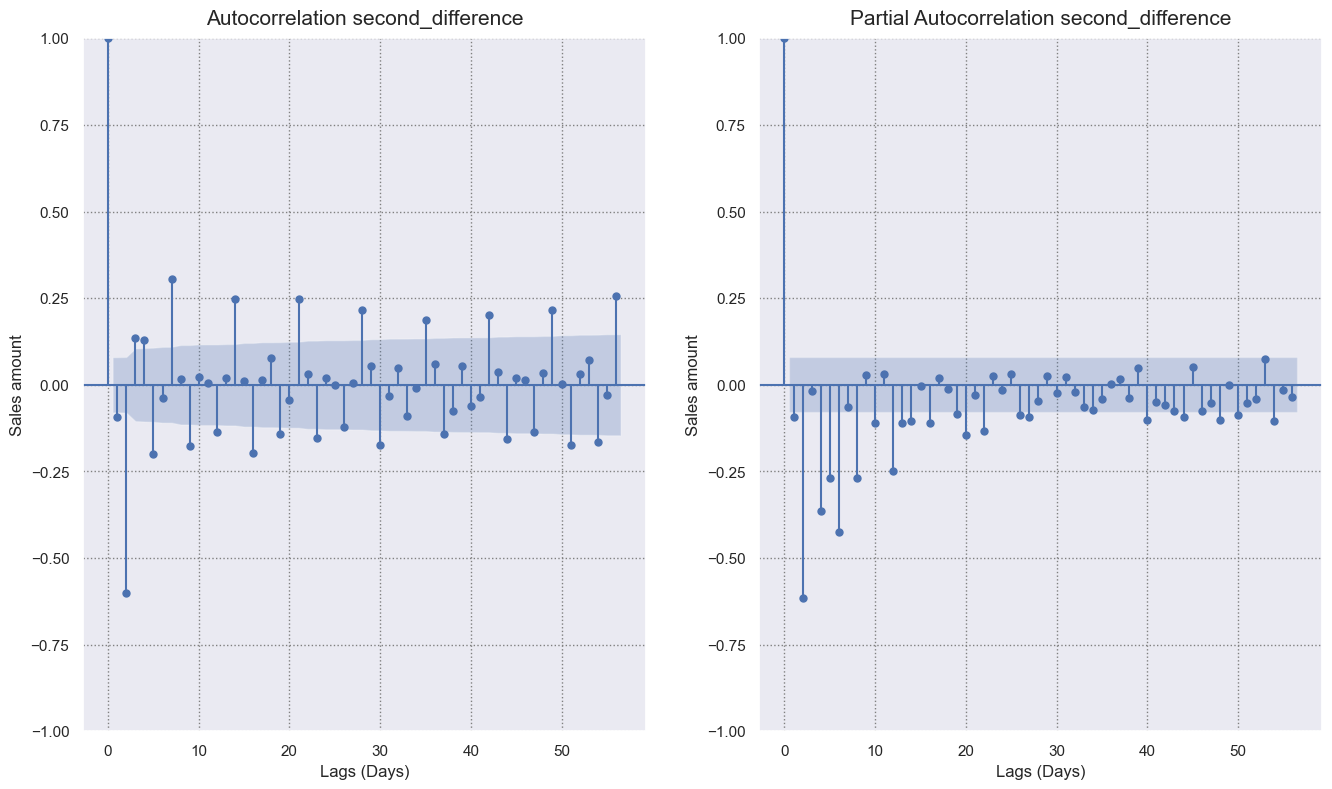

In [73]:
#plotting the ACF and PACF plot for double differenced series
plot_acf_pacf(daily_df['second_difference'].dropna(), acf_lags=56, pacf_lags= 56)

In [74]:
daily_df['third_difference'] = daily_df['day_difference'].diff(3)

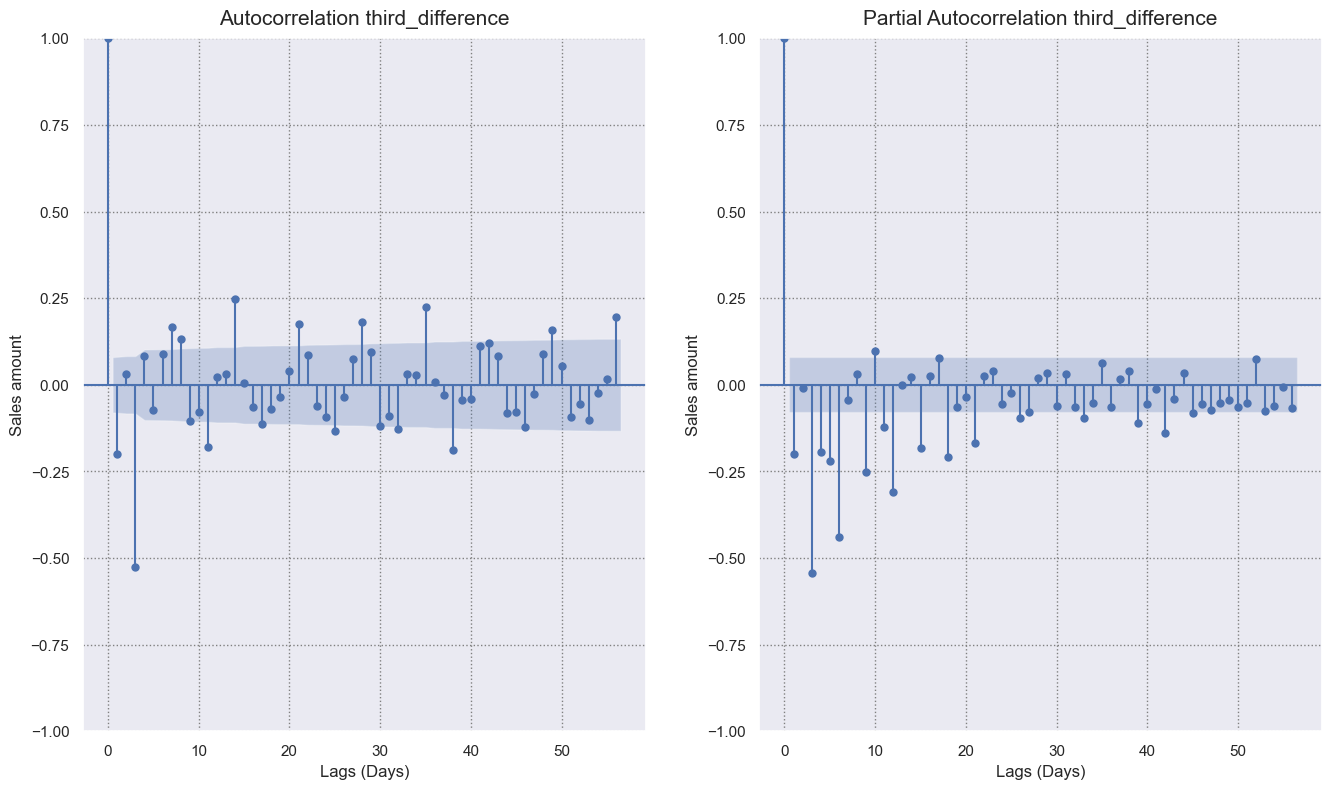

In [75]:
plot_acf_pacf(daily_df['third_difference'].dropna(), acf_lags=56, pacf_lags=56)

In [76]:
#double differencing the column total_amount
daily_df['last_difference'] = daily_df['day_difference'].diff(7)

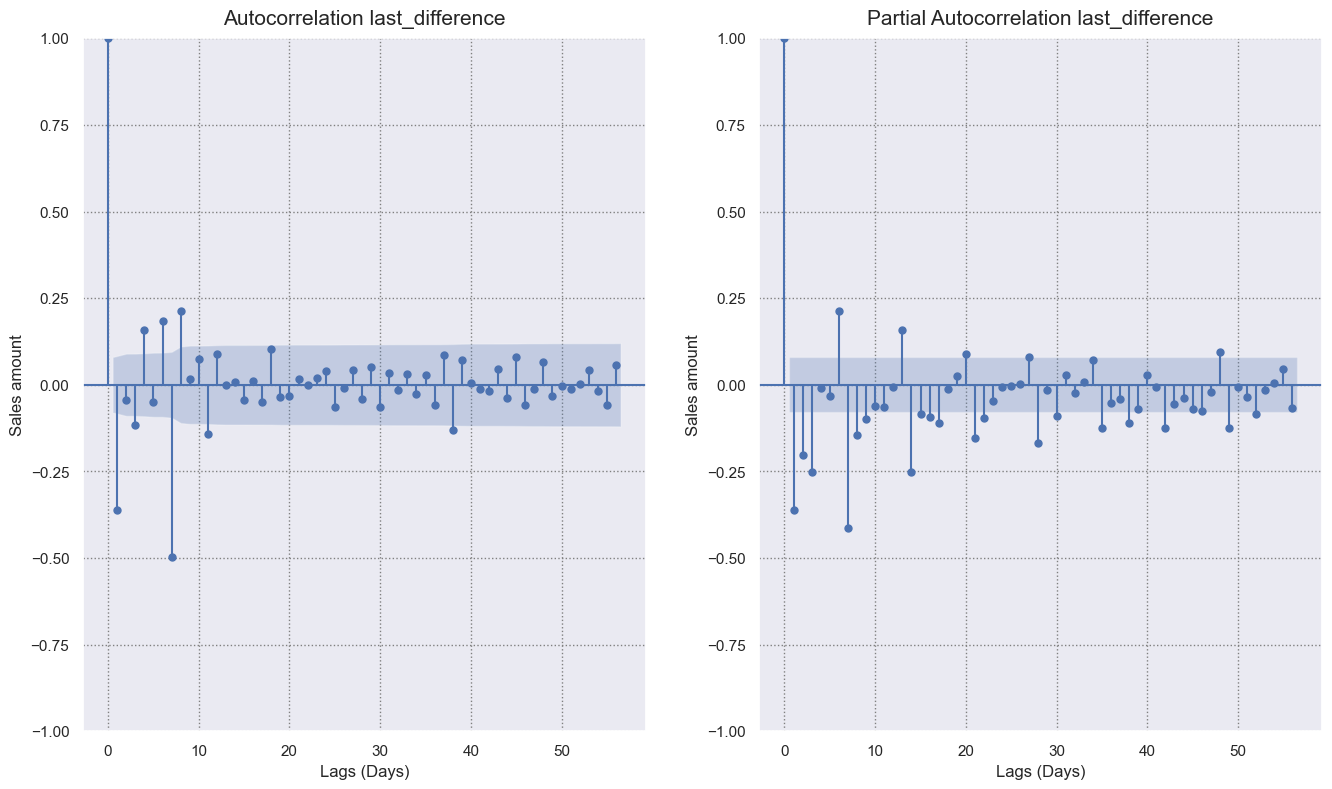

In [77]:
plot_acf_pacf(daily_df['last_difference'].dropna(), acf_lags=56, pacf_lags=56)

#### Observation:

It little difficult to tell, what values of  p and  q are appropriate for the data but we will try to find the appropriate orders.

ACF plot:
- A lot of lags have become zero now. There are few lags that are significant 1, 4, 6, 7 and 8. 
- We can use non seasonal MA of order 1, 4, 6 but the most significant lag is 1.
- The lag at 7 is also important and can help determing the seasonal MA component.

PACF plot:
- It shows signigicant peaks at every seasonal lag of 7 days and peaks are diminishing. Also the non-seasonal lags are also diminishing. So we can use seasonl and non-seasonal MA components in model. The MA components can be determined using the significant lags from ACF plot.
- Apart from seasonl lags, the lag of 1, 2 and 3 are also significant. We can one of these lags for our non-seasonl AR component. 

## 5.2 Applying SARIMA model  <a name="Baseline"></a>
---

The SARIMA model is specified 

$$SARIMA(p, d, q) \times (P, D, Q)_s$$

Where:
- Trend Elements are:
    - p: Autoregressive order
    - d: Difference order
    - q: Moving average order
- Seasonal Elements are:
    - P: Seasonal autoregressive order.
    - D: Seasonal difference order. D=1 would calculate a first order seasonal difference
    - Q: Seasonal moving average order. Q=1 would use a first order errors in the model
    - s: Single seasonal period

#### Theoretical estimates:
- **s**: In our PACF plot there is peak that reappears every 7 days. Thus, we can set seasonal period to **s = 7**. This also backed by our seasonal component after additive decomposition.
- **p**: We observed that there is some tappering in ACF plot and we found the significant lags of 1,2,3 from PACF plot. We can start with **p=1** and see how it works. 
- **d**: We observed that our series has some trend, so we can remove it by differencing, so **d = 1**.
- **q**: Based on our ACF correlations we can set **q = 1** since its the most significant lag. 
- **P**: **P = 0** as we are using ACF plot to find seasonl significant lag. 
- **D**: Since we are dealing with seasonality and we need to differnce the series, **D = 1**
- **Q**: The seasonal moving average will be set to **Q = 1** as we found only one significant seasonal lag in ACF plot. 
Here we go:

$$ SARIMA(1, 1, 1) \times (0, 1, 1)_{7} $$

### Baseline Sarima Model


In [78]:
# Set Hyper-parameters
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 1
s = 7

# Fit SARIMA
sarima_model = SARIMAX(train_df['total_amount'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_model_fit = sarima_model.fit(disp=0)
print(sarima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      total_amount   No. Observations:                  485
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4993.088
Date:                           Wed, 03 Dec 2025   AIC                           9994.176
Time:                                   15:34:55   BIC                          10010.846
Sample:                               01-01-2017   HQIC                         10000.731
                                    - 04-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2760      0.046      6.041      0.000       0.186       0.366
ma.L1         -0.8352      0.036    -23.014

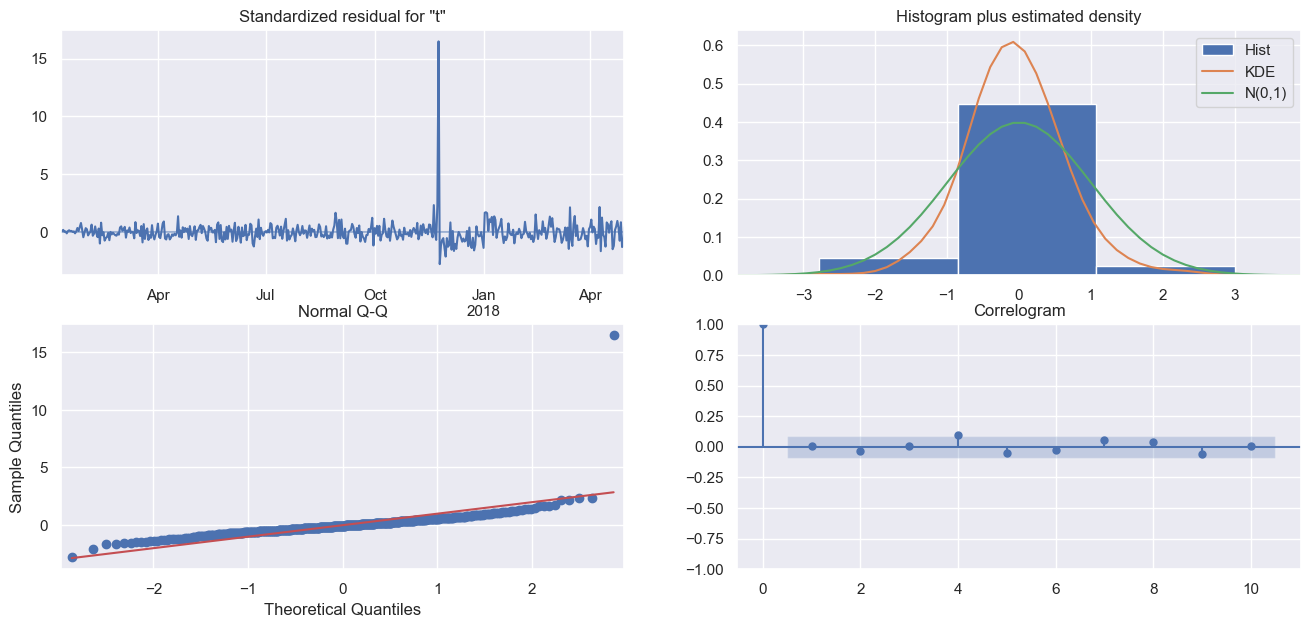

In [79]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(16, 7))
plt.show()

#### Observations: 

Standardized Residuals Plot:

The top-left plot shows the standardized residuals of the model over time.
Ideally, you want to see the residuals distributed randomly around the zero line, which would indicate that the model's predictions are unbiased.
Large spikes might indicate outliers or periods where the model did not predict accurately.

Normal Q-Q Plot:

The bottom-left plot is a Quantile-Quantile plot that compares the distribution of the standardized residuals to a normal distribution.
The red line represents what the plot of residuals would look like if they were perfectly normally distributed. The dots are the actual residuals.
If the residuals are normally distributed, the dots should lie approximately along this line.
Deviations from the line at the ends suggest that the residuals have fat tails or outliers.

Histogram Plus Estimated Density:

The top-right plot includes a histogram (blue bars) which shows the distribution of the standardized residuals, overlaid with a Kernel Density Estimation (KDE, green curve) and the expected normal distribution (N(0,1), orange curve).
This plot provides another view of how well the residuals match a normal distribution.
A well-fitting model should have the KDE closely match the N(0,1) curve.

Correlogram (ACF Plot):

The bottom-right plot is an autocorrelation plot of the standardized residuals.
It shows the correlations of the residuals with lagged versions of themselves.
In a good model, the correlations should be very low, which would appear as bars within the blue shaded area (confidence interval).
Any bars that extend beyond the blue area indicate significant autocorrelation at that lag, which implies that the model has not fully captured the underlying process.

From your plots:

The **Standardized Residuals** plot shows some large spikes which may indicate potential outliers or periods of poor model fit.


The **Normal Q-Q plot** indicates that the residuals might not be normally distributed, as there are deviations from the red line.


The **Histogram Plus Estimated Density** plot shows that the distribution of residuals has heavier tails than the normal distribution, suggesting that the data is more spread out than expected.


The **Correlogram** shows that the residuals have low autocorrelation, as most of the lags are within the confidence interval, which is a good sign.


These diagnostics suggest that while the autocorrelation in residuals is not a major issue, the distribution of residuals does not quite follow a normal distribution, and there may be outliers affecting the model. This could be addressed by investigating outliers, applying transformations, or considering different models or additional explanatory variables.

## 5.3 Plotting predictions and evaluating SARIMA model
<a id="plot"></a>

#### Prediction using SARIMA

In [80]:
test_df

,total_amount
order_purchase_timestamp,
2018-05-01,38441.68
2018-05-02,44764.32
2018-05-03,49575.72
2018-05-04,45494.10
2018-05-05,32608.15
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [81]:
test_df.index[0]

Timestamp('2018-05-01 00:00:00')

In [82]:
test_df.index[-1]

Timestamp('2018-09-03 00:00:00')

In [83]:
test_df['total_amount']

order_purchase_timestamp
2018-05-01    38441.68
2018-05-02    44764.32
2018-05-03    49575.72
2018-05-04    45494.10
2018-05-05    32608.15
                ...   
2018-08-30        0.00
2018-08-31        0.00
2018-09-01        0.00
2018-09-02        0.00
2018-09-03      166.46
Freq: D, Name: total_amount, Length: 126, dtype: float64

In [84]:
# Defining Prediction period
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarima_predictions = sarima_model_fit.predict(start = pred_start_date, end = pred_end_date)
sarima_residuals = test_df['total_amount'], sarima_predictions

In [85]:
sarima_predictions

2018-05-01    40560.860004
2018-05-02    39900.189854
2018-05-03    38733.695140
2018-05-04    39018.444085
2018-05-05    33064.473976
                  ...     
2018-08-30    47656.161923
2018-08-31    47941.098118
2018-09-01    41987.179691
2018-09-02    43008.327483
2018-09-03    50471.901089
Freq: D, Name: predicted_mean, Length: 126, dtype: float64

In [86]:
sarima_residuals

(order_purchase_timestamp
 2018-05-01    38441.68
 2018-05-02    44764.32
 2018-05-03    49575.72
 2018-05-04    45494.10
 2018-05-05    32608.15
                 ...   
 2018-08-30        0.00
 2018-08-31        0.00
 2018-09-01        0.00
 2018-09-02        0.00
 2018-09-03      166.46
 Freq: D, Name: total_amount, Length: 126, dtype: float64,
 2018-05-01    40560.860004
 2018-05-02    39900.189854
 2018-05-03    38733.695140
 2018-05-04    39018.444085
 2018-05-05    33064.473976
                   ...     
 2018-08-30    47656.161923
 2018-08-31    47941.098118
 2018-09-01    41987.179691
 2018-09-02    43008.327483
 2018-09-03    50471.901089
 Freq: D, Name: predicted_mean, Length: 126, dtype: float64)

In [87]:
train_df

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27
...,...
2018-04-26,36912.77
2018-04-27,46763.07
2018-04-28,26978.52


#### Evaluation of SARIMA

In [88]:
sarima_rmse = rmse_metrics(test_df['total_amount'], sarima_predictions)
sarima_mape = mape_metrics(test_df['total_amount'], sarima_predictions)

print(f'Root Mean Squared Error | RMSE: {sarima_rmse}')
print(f'Mean Absolute Percentage Error | MAP: {sarima_mape}')

Root Mean Squared Error | RMSE: 17042.99
Mean Absolute Percentage Error | MAP: inf


#### Plotting test and Prediction

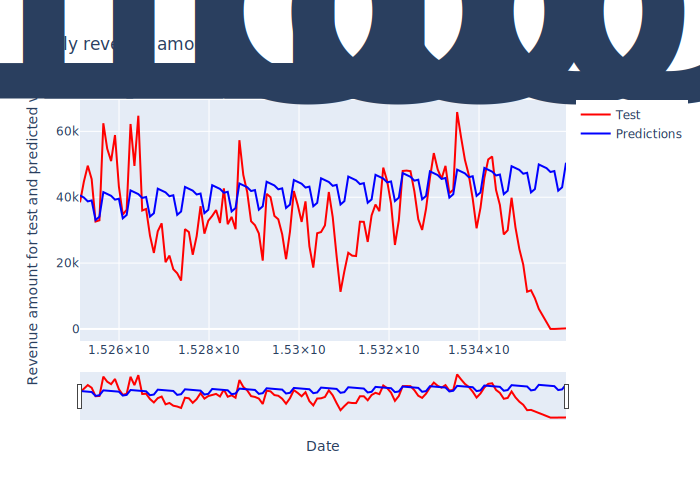

In [89]:
plot_test_predictions(test_df['total_amount'], sarima_predictions)

#### Observations:

Our baseline model is able to capture the seasonality and trend component but is not able to pick up the variations between weeks. The MAPE is also very high.

#### Sarima Forecast
We will try to forecast the sales for next 180 days. We have the 121 days known from our test data and we will try to see what our model forcasts for next 60 days.

In [90]:
# Forecast Window

days = 360

sarima_forecast = sarima_model_fit.forecast(days)
sarima_forecast_series = pd.Series(sarima_forecast, index=sarima_forecast.index)

# Since negatice orders are not possible we can trim them out.
sarima_forecast_series[sarima_forecast_series < 0] = 0

In [91]:
sarima_forecast.isnull().sum()

0

In [92]:
sarima_forecast_series.isnull().sum()

0

#### Plotting Forecast using Baseline SARIMA

In [93]:
plot_forecast

<function __main__.plot_forecast(train_set, test_set, fc_series: pandas.core.series.Series) -> None>

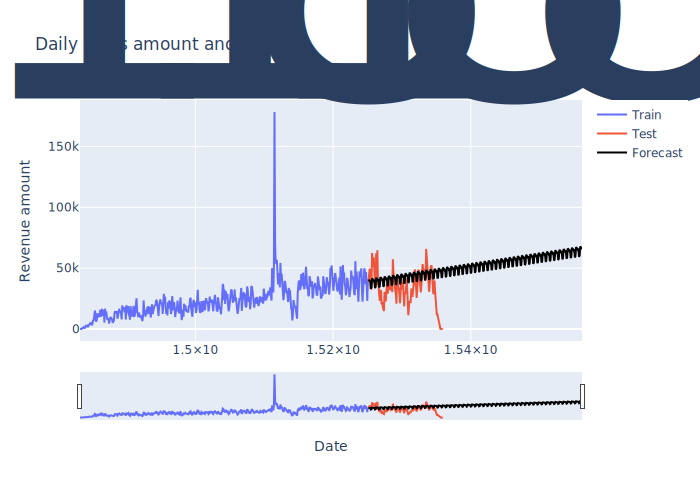

In [94]:
plot_forecast(train_df['total_amount'], test_df['total_amount'], sarima_forecast_series)

#### Observations:

- The model predicts the overall daily patterns pretty well.
- We will need to tune it further and should also add another feature holiday so that it can pick some informations from that.


## 5.4 Adding Exogenous variable holiday for SARIMAX

<a id="SARIMAAX"></a>

Let us include the exogenous variable holiday to imporve our model.

In [95]:
# Read data from holida file
holiday = pd.read_csv(r"D:\YZU\763  AI\AI-Powered-Sales-Analysis-Forecasting-for-Business-Growth\holiday.csv", index_col=0)



In [96]:
holiday.head()

,is_holiday
1/1/2017,1
2/27/2017,1
2/28/2017,1
3/1/2017,1
4/14/2017,1


In [97]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 1/1/2017 to 12/25/2018
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   is_holiday  36 non-null     int64
dtypes: int64(1)
memory usage: 576.0+ bytes


In [98]:
holiday.index

Index(['1/1/2017', '2/27/2017', '2/28/2017', '3/1/2017', '4/14/2017',
       '4/21/2017', '5/1/2017', '6/15/2017', '7/9/2017', '8/13/2017',
       '9/7/2017', '10/12/2017', '10/27/2017', '11/1/2017', '11/2/2017',
       '11/15/2017', '11/20/2017', '12/25/2017', '1/1/2018', '1/25/2018',
       '2/12/2018', '2/13/2018', '3/30/2018', '4/21/2018', '5/1/2018',
       '5/13/2018', '5/31/2018', '7/9/2018', '8/12/2018', '9/7/2018',
       '10/12/2018', '10/29/2018', '11/2/2018', '11/15/2018', '11/20/2018',
       '12/25/2018'],
      dtype='object')

In [99]:
# Converting index to datetime
holiday.index = pd.to_datetime(holiday.index)

In [100]:
holiday.head()

,is_holiday
2017-01-01,1
2017-02-27,1
2017-02-28,1
2017-03-01,1
2017-04-14,1


Our holiday dataframe only has dates when there is a holiday but not all the dates. We can fill the missing dates and change the is_holiday column to int format.

In [101]:
# Fill the missing dates
idx = pd.date_range('2017-01-01', '2018-12-31')
holiday = holiday.reindex(idx, fill_value = 0)
#convert holiday column to 'int' type
holiday['is_holiday'] = holiday['is_holiday'].astype(int)

In [102]:
holiday.head()

,is_holiday
2017-01-01,1
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0


In [103]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2017-01-01 to 2018-12-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   is_holiday  730 non-null    int32
dtypes: int32(1)
memory usage: 8.6 KB


Since our data has impact of Black friday, we can add few holidays like Valentine day and black friday day as holiday.

In [104]:
# adding some more days as holidays like Valentine day and black friday
# Feb 14, Nov 24 2017 and Nov 23 2018
holiday.loc[((holiday.index.day==14) & (holiday.index.month==2)), :]=1
holiday.loc[((holiday.index=='2017-11-24') | (holiday.index=='2018-11-23')),:]=1

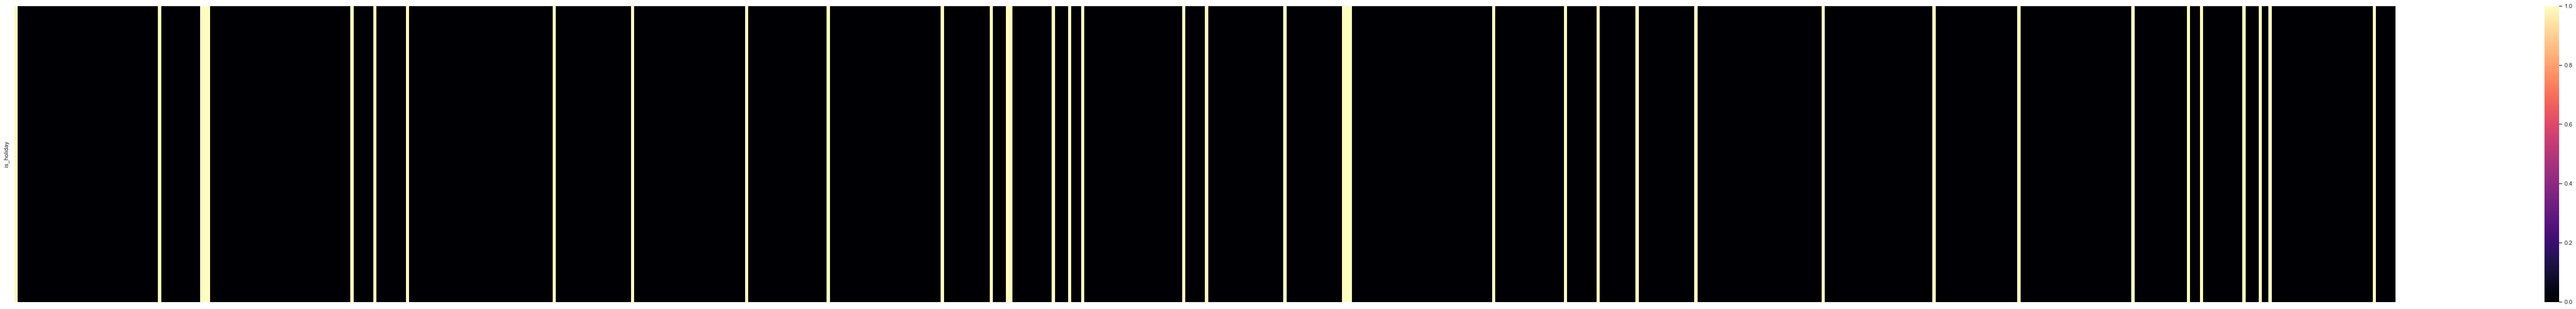

In [105]:
# Plot to show holidays
plt.figure(figsize=(100,10))
sns.heatmap(holiday.T, cmap="magma", xticklabels=[])
plt.show()

In [106]:
# Filling the holidays only upto the edn of our test data period.
holiday_df = holiday.loc[holiday.index<='2018-08-29']

In [107]:
holiday_df

,is_holiday
2017-01-01,1
2017-01-02,0
2017-01-03,0
2017-01-04,0
2017-01-05,0
...,...
2018-08-25,0
2018-08-26,0
2018-08-27,0
2018-08-28,0


In [108]:
daily_data

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [109]:
final_df = pd.concat([daily_data,holiday_df],axis=1)

In [110]:
import pandas as pd
final_df.to_csv('/final_data.csv')

In [111]:
# Adding the holiday data to our new df
dfex = pd.concat([daily_data, holiday_df], axis=1)

In [112]:
dfex

,total_amount,is_holiday
2017-01-01,0.00,1.0
2017-01-02,0.00,0.0
2017-01-03,0.00,0.0
2017-01-04,0.00,0.0
2017-01-05,707.27,0.0
...,...,...
2018-08-30,0.00,NaN
2018-08-31,0.00,NaN
2018-09-01,0.00,NaN
2018-09-02,0.00,NaN


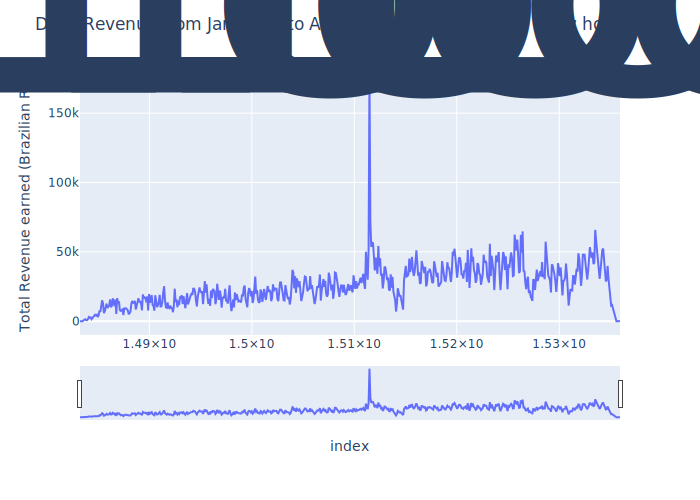

In [113]:
#plotting daily data to get high level picture

fig = px.line(dfex, x=dfex.index, y='total_amount')

# axis labels and title
fig.update_layout(
    yaxis_title="Total Revenue earned (Brazilian Real)", 
    legend_title="", 
    title="Daily Revenue from Jan 2017 to Aug 2018 \n(Red dash lines show holidays)"
)
v_line=dfex.loc[dfex['is_holiday']==1].index
for idx in v_line:
    fig.add_vline(idx,line_width=0.5, line_dash="dash", line_color="red")

# activate slider
fig.update_xaxes(rangeslider_visible=True)

# fig.show()
fig.show("svg")

#### SARIMAX using an Exogenous variable

We can split the df into test and train so that we can do some modelling on it.

In [114]:
# Splitting into the test and train
train_dfex, test_dfex = train_test_split(dfex, train_end, test_end)

## 5.5 Applying grid search on SARIMAX with exogenous variable

<a id="Grid_search"></a>

In [115]:
print(train_dfex['is_holiday'].isna().sum())  # số giá trị NaN
print(test_dfex['is_holiday'].isna().sum())

print(train_dfex['is_holiday'].unique())     # kiểm tra các giá trị lạ
print(test_dfex['is_holiday'].unique())


0
5
[1. 0.]
[ 1.  0. nan]


In [116]:
train_dfex['is_holiday'] = train_dfex['is_holiday'].fillna(0)
test_dfex['is_holiday'] = test_dfex['is_holiday'].fillna(0)


In [117]:
#instantiating order variables
p = range(1, 5)
d = range(1,2)
q = range(1, 3)
s = 7

P=range(0,1)

D=range(1,2)
Q=range(1,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq=list(itertools.product(P, D, Q))
seasonal_PDQS= [(x[0], x[1], x[2], s) for x in seasonal_pdq]


def grid_search_sarimax(train_set, test_set) -> None:
    """
    This function perform a grid search for SARIMAX model Hyper-Parameters.
    ---
    Args:
        train_set (pd.DataFrame): Training set for grid search.
        
    Returns: None
    """
    # Supress UserWarnings
    warnings.simplefilter('ignore', category=UserWarning)
    
    #instantiating variables
    pred_start_date = test_set.index[0]
    pred_end_date = test_set.index[-1]
    summary=pd.DataFrame(columns=['Model', 'AIC', 'BIC', 'MSE', 'SSE', 'RMSE', 'MAPE'])
    data={}
    # Grid Search
    for order in pdq:
        for seasonal_order in seasonal_PDQS:
            model = SARIMAX(train_set['total_amount'],
                            order=order,
                            seasonal_order=seasonal_order,
                            exog=(train_set[['is_holiday']]))
            results = model.fit(disp=0)
            predictions = results.predict(start=pred_start_date, end=pred_end_date, 
                                          exog=(test_set[['is_holiday']]))
            
            data= { "Model":f'{order}x{seasonal_order}',
                    "AIC":results.aic, 
                    "BIC":results.bic,
                    "MSE":results.mse, 
                    "SSE":results.sse,
                    "RMSE": rmse_metrics(test_set['total_amount'], predictions),
                    "MAPE": mape_metrics(test_set['total_amount'], predictions) }

            summary=pd.concat([summary, pd.DataFrame(data, columns=summary.columns, index=[1])], ignore_index=True)
            
    return summary


grid_search_sarimax(train_dfex, test_dfex)

,Model,AIC,BIC,MSE,SSE,RMSE,MAPE
0,"(1, 1, 1)x(0, 1, 1, 7)",9994.212982,10015.050565,6.949390e+07,3.370454e+10,15700.48,inf
1,"(1, 1, 1)x(0, 1, 2, 7)",9994.731211,10019.736310,6.922149e+07,3.357242e+10,16053.11,inf
2,"(1, 1, 2)x(0, 1, 1, 7)",10081.345219,10106.350318,6.986077e+07,3.388247e+10,15056.93,inf
3,"(1, 1, 2)x(0, 1, 2, 7)",10014.431145,10043.603760,7.197748e+07,3.490908e+10,14560.15,inf
4,"(2, 1, 1)x(0, 1, 1, 7)",10075.010416,10100.015515,7.006158e+07,3.397987e+10,16220.48,inf
5,"(2, 1, 1)x(0, 1, 2, 7)",10074.521220,10103.693836,6.884955e+07,3.339203e+10,17427.09,inf
6,"(2, 1, 2)x(0, 1, 1, 7)",10082.964089,10112.136705,6.985967e+07,3.388194e+10,15054.96,inf
7,"(2, 1, 2)x(0, 1, 2, 7)",10001.150201,10034.490333,6.872739e+07,3.333278e+10,19030.43,inf
8,"(3, 1, 1)x(0, 1, 1, 7)",10074.714142,10103.886757,6.977202e+07,3.383943e+10,15191.21,inf
9,"(3, 1, 1)x(0, 1, 2, 7)",10073.510715,10106.850847,6.803517e+07,3.299706e+10,17564.09,inf


SARIMA Order (1,1,2) x (0, 1,1,7) gives the minimum MAPE and RMSE on the test data. We will chose this model as a better model over our baseline.

#### Fitting the model on tuned SARIMAX

In [118]:
# Set Hyper-parameters
p, d, q = 1, 1, 2
P, D, Q = 0, 1, 1
s = 7

# Fit SARIMA
sarimax_model = SARIMAX(train_dfex['total_amount'], 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       exog=(train_dfex[['is_holiday']]))
sarimax_model_fit = sarimax_model.fit(disp=0)
print(sarimax_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        total_amount   No. Observations:                  485
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -5034.673
Date:                             Wed, 03 Dec 2025   AIC                          10081.345
Time:                                     15:35:52   BIC                          10106.350
Sample:                                 01-01-2017   HQIC                         10091.177
                                      - 04-30-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  4312.2796   1417.870      3.041      0.002    1533.306    7091.253
ar.L1          0.1398      

## 5.6 Plotting predictions and evaluating SARIMAX model

<a id="plot_sarimax"></a>

#### Prediction using tuned SARIMAX 

In [119]:
#predicting 
pred_start_date = test_df.index[0]
pred_end_date = test_df.index[-1]

sarimax_predictions = sarimax_model_fit.predict(start=pred_start_date, end=pred_end_date, exog=(test_dfex[['is_holiday']]) )

In [120]:
sarimax_predictions

2018-05-01    45208.948322
2018-05-02    41094.117125
2018-05-03    39032.027178
2018-05-04    37375.125658
2018-05-05    28786.758650
                  ...     
2018-08-30    43456.488240
2018-08-31    41797.278759
2018-09-01    33208.589015
2018-09-02    36314.216753
2018-09-03    47258.796624
Freq: D, Name: predicted_mean, Length: 126, dtype: float64

#### Evaluation of tuned SARIMAX

In [121]:
sarimax_rmse = rmse_metrics(test_dfex['total_amount'], sarimax_predictions)
sarimax_mape = mape_metrics(test_dfex['total_amount'], sarimax_predictions)

print(f'Root Mean Squared Error | RMS: {sarimax_rmse}')
print(f'Mean Absolute Percentage Error | MAPE: {sarimax_mape}')

Root Mean Squared Error | RMS: 15056.93
Mean Absolute Percentage Error | MAPE: inf


#### Plotting test and predictions of tuned SARIMAX

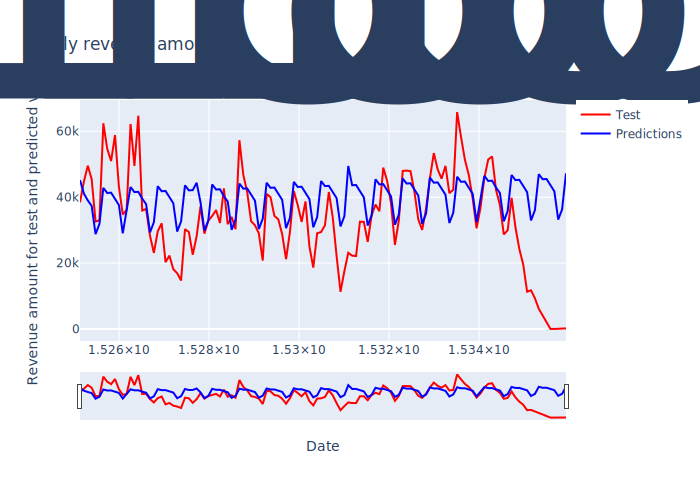

In [122]:
plot_test_predictions(test_dfex['total_amount'], sarimax_predictions)

### SARIMAX Forecast

In [123]:
# Forecast Window
exog=holiday.loc[(holiday.index> '2018-04-30') & (holiday.index<= '2018-10-27') ]
exog_df=exog.copy()

days = 180
exog_param=(exog_df[['is_holiday']])
sarimax_forecast = sarimax_model_fit.forecast(days, exog=exog_param)
sarimax_forecast_series = pd.Series(sarimax_forecast, index=sarimax_forecast.index)

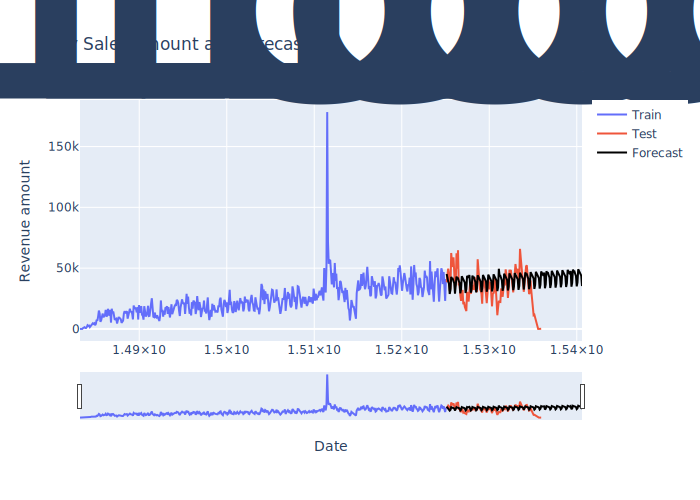

In [124]:
plot_forecast(train_dfex['total_amount'], test_dfex['total_amount'], sarimax_forecast_series)

### Observations:
- Although our MAPE and RMSE have been reduced after introduction of holidays and tuning the order but still the model is unable to perform well.
- It is capturing some small peaks but not very accurately. 
- We can try some othe models and see how they perform.

# 6. Modelling (XG Boost Regression)

<a id="xg_boost"></a>

XGBoost is an efficient implementation of gradient boosting that can be used for regression predictive modeling. We will try to implement this model.

For XGBoost we cannot feed a time series as such, we will have to extract date time features from our order timestamp to make up the independent variables in order to predict 'total_amount'.

## 6.1 Preparing data for XG Boost Regression

<a id ="xg_boost_prep"></a>

We will be creating a function to extract features from date. We will also add holiday as a feature.

In [125]:
#function to extract features from date
def create_features(dataframe, label=None):
    df=dataframe.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear','dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [126]:
#creating dataframe with only required columns
daily_data_xgb=dfex[['total_amount', 'is_holiday']]

In [127]:
daily_data_xgb

,total_amount,is_holiday
2017-01-01,0.00,1.0
2017-01-02,0.00,0.0
2017-01-03,0.00,0.0
2017-01-04,0.00,0.0
2017-01-05,707.27,0.0
...,...,...
2018-08-30,0.00,NaN
2018-08-31,0.00,NaN
2018-09-01,0.00,NaN
2018-09-02,0.00,NaN


In [128]:
daily_data_xgb.isnull().sum()

total_amount    0
is_holiday      5
dtype: int64

In [129]:
#Separating X and y
X, y = create_features(daily_data_xgb, label='total_amount')
X['is_holiday'] = daily_data_xgb['is_holiday']

In [130]:
X

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_holiday
2017-01-01,6,1,1,2017,1,1,52,1.0
2017-01-02,0,1,1,2017,2,2,1,0.0
2017-01-03,1,1,1,2017,3,3,1,0.0
2017-01-04,2,1,1,2017,4,4,1,0.0
2017-01-05,3,1,1,2017,5,5,1,0.0
...,...,...,...,...,...,...,...,...
2018-08-30,3,3,8,2018,242,30,35,NaN
2018-08-31,4,3,8,2018,243,31,35,NaN
2018-09-01,5,3,9,2018,244,1,35,NaN
2018-09-02,6,3,9,2018,245,2,35,NaN


In [131]:
from datetime import datetime, timedelta

# Define the start and end dates
start_date = datetime(2017, 1, 1)
end_date = datetime(2018, 8, 29)

# Calculate the total number of days in the data range
total_days = (end_date - start_date).days

# Calculate the number of days for the training set (80% of the total)
train_days = int(0.8 * total_days)

# Calculate the train end date
train_end_date = start_date + timedelta(days=train_days)

# Calculate the test end date
test_end_date = train_end_date + timedelta(days=1)

print("Train end date:", train_end_date)
print("Test end date:", test_end_date)

Train end date: 2018-04-30 00:00:00
Test end date: 2018-05-01 00:00:00


In [132]:
# Splitting the data for train and test split

train_end = '2018-4-30'
test_end = '2018-8-29'

X_train, X_test = train_test_split(X, train_end, test_end)
y_train, y_test = train_test_split(y, train_end, test_end)

## 6.2 Baseline model on daily data and its performance

<a id ="xg_baseline"></a>

Let us apply a baseline XG Boost Regression and we will then evaluate its performance.

In [133]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters
params = {
    "max_depth": 3,
    "eta": 0.1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

# Train with early stopping
evals = [(dtrain, "train"), (dtest, "eval")]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)


[0]	train-rmse:13342.23848	eval-rmse:16405.67449
[1]	train-rmse:12671.82594	eval-rmse:15703.59718
[2]	train-rmse:12097.54457	eval-rmse:15126.14163
[3]	train-rmse:11596.17034	eval-rmse:14613.81238
[4]	train-rmse:11155.43501	eval-rmse:14242.85111
[5]	train-rmse:10782.52898	eval-rmse:13894.28066
[6]	train-rmse:10465.49061	eval-rmse:13646.40633
[7]	train-rmse:10103.46809	eval-rmse:13420.75412
[8]	train-rmse:9771.39214	eval-rmse:13256.29354
[9]	train-rmse:9471.32459	eval-rmse:13119.95016
[10]	train-rmse:9270.00241	eval-rmse:13042.55977
[11]	train-rmse:8946.81436	eval-rmse:12991.48284
[12]	train-rmse:8718.48476	eval-rmse:12947.49537
[13]	train-rmse:8457.65649	eval-rmse:12929.55781
[14]	train-rmse:8216.74611	eval-rmse:12933.78932
[15]	train-rmse:8005.59047	eval-rmse:12942.84228
[16]	train-rmse:7820.91994	eval-rmse:12958.31430
[17]	train-rmse:7563.27609	eval-rmse:12983.43236
[18]	train-rmse:7476.09054	eval-rmse:12996.68453
[19]	train-rmse:7206.98524	eval-rmse:12978.16676
[20]	train-rmse:7075.5

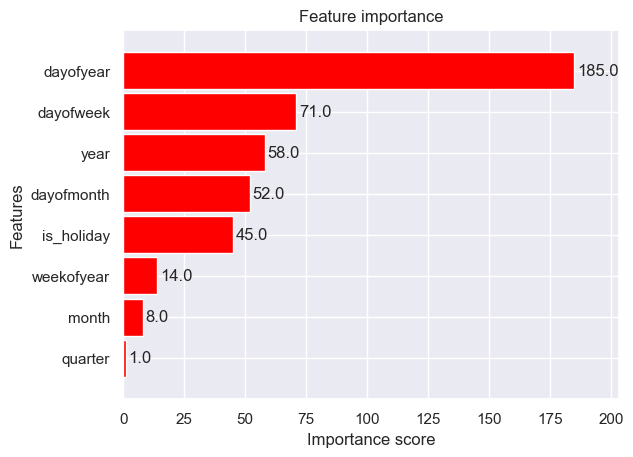

In [134]:
#plot feature importance
plot_importance(model, height=0.9, color='red')
plt.show()

#### Evaluating the perfomance for baseline XGB

In [135]:
# Chuyển X_test thành DMatrix
dtest = xgb.DMatrix(X_test)

# Dự đoán
predictions_xgb = model.predict(dtest)  # model là Booster trả về từ xgb.train()

# Tính MAPE và RMSE
mape_xgb = mape_metrics(y_test, predictions_xgb)
rmse_xgb = rmse_metrics(y_test, predictions_xgb)

print(f'Root Mean Squared Error | RMSE: {rmse_xgb}')
print(f'Mean Absolute Percentage Error | MAPE: {mape_xgb}')

Root Mean Squared Error | RMSE: 13197.61
Mean Absolute Percentage Error | MAPE: inf


In [136]:
#if doing forecasting
start_date=datetime(2018,8,30)
end_date=start_date+pd.DateOffset(days=30)
full_range = pd.date_range(start=start_date, end=end_date, freq="D")
filtered_data= holiday.loc[(holiday.index >= start_date) & (holiday.index <= end_date)]
forecast_df=pd.DataFrame(data=filtered_data, index=full_range, columns=['is_holiday'])

In [137]:
# Create a feature for new dates
X_forecast = create_features(forecast_df)

In [138]:
X_forecast.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2018-08-30,3,3,8,2018,242,30,35
2018-08-31,4,3,8,2018,243,31,35
2018-09-01,5,3,9,2018,244,1,35
2018-09-02,6,3,9,2018,245,2,35
2018-09-03,0,3,9,2018,246,3,36


In [139]:
forecast_df['is_holiday']

2018-08-30    0
2018-08-31    0
2018-09-01    0
2018-09-02    0
2018-09-03    0
2018-09-04    0
2018-09-05    0
2018-09-06    0
2018-09-07    1
2018-09-08    0
2018-09-09    0
2018-09-10    0
2018-09-11    0
2018-09-12    0
2018-09-13    0
2018-09-14    0
2018-09-15    0
2018-09-16    0
2018-09-17    0
2018-09-18    0
2018-09-19    0
2018-09-20    0
2018-09-21    0
2018-09-22    0
2018-09-23    0
2018-09-24    0
2018-09-25    0
2018-09-26    0
2018-09-27    0
2018-09-28    0
2018-09-29    0
Freq: D, Name: is_holiday, dtype: int32

In [140]:
X_forecast['is_holiday'] = forecast_df['is_holiday']

In [141]:
X_forecast

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_holiday
2018-08-30,3,3,8,2018,242,30,35,0
2018-08-31,4,3,8,2018,243,31,35,0
2018-09-01,5,3,9,2018,244,1,35,0
2018-09-02,6,3,9,2018,245,2,35,0
2018-09-03,0,3,9,2018,246,3,36,0
2018-09-04,1,3,9,2018,247,4,36,0
2018-09-05,2,3,9,2018,248,5,36,0
2018-09-06,3,3,9,2018,249,6,36,0
2018-09-07,4,3,9,2018,250,7,36,1
2018-09-08,5,3,9,2018,251,8,36,0


In [142]:
# make forecast
dforecast = xgb.DMatrix(X_forecast)
xgb_forecast = model.predict(dforecast)  # model là Booster từ xgb.train()

In [143]:
# Chuyển dữ liệu forecast thành DMatrix
dforecast = xgb.DMatrix(X_forecast)

# Dự báo với Booster
xgb_forecast = model.predict(dforecast)  # model là Booster từ xgb.train()

# Kiểm tra kết quả
print(xgb_forecast)

[39563.566 33921.82  30762.977 31641.922 44238.992 43707.637 42960.32
 41487.887 30660.184 28565.906 30272.504 44421.605 43707.637 42763.66
 41123.47  36039.773 29168.098 30874.695 44691.793 44520.984 42566.816
 40993.203 35568.242 28426.37  30132.967 43697.22  43559.81  42497.055
 41013.746 34301.383 26423.639]


In [144]:
dforecast = xgb.DMatrix(X_forecast)
xgb_forecast = model.predict(dforecast)  # Lưu ý: tên là xgb_forecast

# creating dataframe for all y columns
xgb_forecast_df = pd.DataFrame(xgb_forecast, forecast_df.index, columns=['Forecast'])



In [145]:
pred_xgb_df = pd.DataFrame({'Predictions': predictions_xgb})


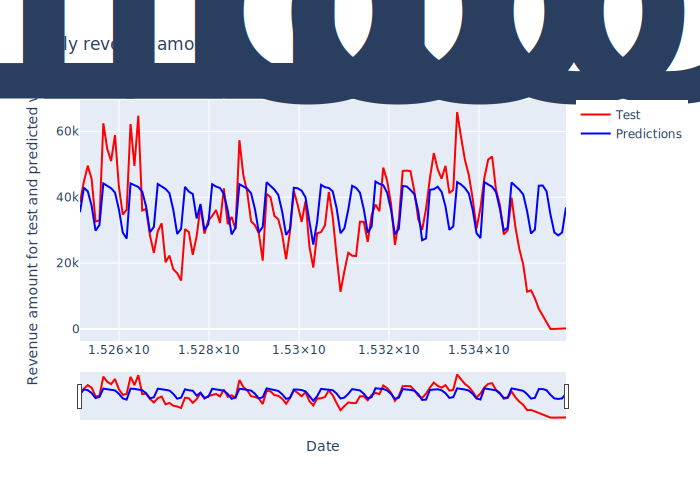

In [146]:
# Convert y_test into a DataFrame so you can use ['total_amount']
y_test_df = pd.DataFrame(y_test, columns=['total_amount'])

# Now plot
plot_test_predictions(y_test_df['total_amount'], predictions_xgb)


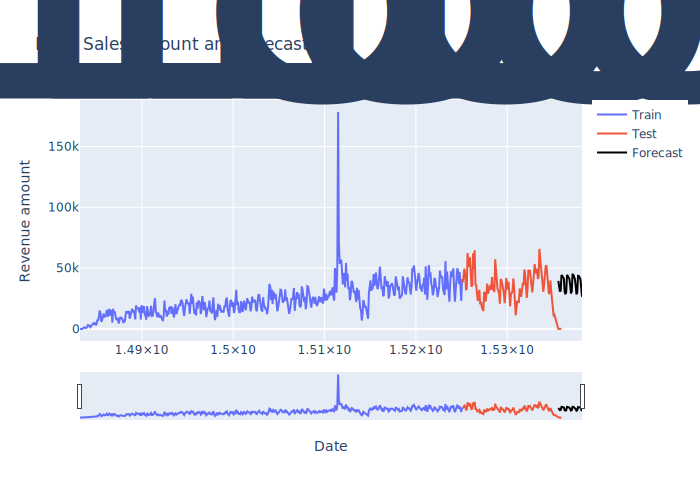

In [147]:
# Convert y_train and y_test into DataFrames
y_train_df = pd.DataFrame(y_train, columns=['total_amount'])
y_test_df = pd.DataFrame(y_test, columns=['total_amount'])

# Now you can plot the forecast
plot_forecast(y_train_df['total_amount'], y_test_df['total_amount'], xgb_forecast_df['Forecast'])


#### Observations:

- Uponn plotting both test and predicted values we can see that the predicted series is just picking the seasonality but not the pattern within the week.
- It looks like it has constant trend. 
- **Although it is not capturing the noise but it I think beacuse of limited datapoints it is not performing well.**

## 6.3 Tuning XG Boost and evaluating and its performance

<a id = 'xg_tuned' ></a>

In [148]:
num_estimators = [i for i in range(100, 1010, 100)]
depth = [i for i in range(3,15,2)]
learning = [0.0001, 0.001, 0.1, 0.2, 0.3]

In [ ]:
XGB_summary=pd.DataFrame(columns=['n_estimators', 'max_depth', 'learning_rate', 'MAPE', 'RMSE' ])

for i in num_estimators:
    for j in depth:
        for k in learning:
            model_reg= xgb.XGBRegressor(n_estimators=i, max_depth=j, learning_rate=k )
            model_reg.fit(X_train, y_train)
            predictions_xgb = model_reg.predict(X_test)
            mape_xgb=np.mean(np.abs((y_test - predictions_xgb)/y_test))*100
            rmse_xgb = np.sqrt(np.mean((y_test-predictions_xgb)**2))
            data_param={'n_estimators': i,
                        'max_depth': j,
                        'learning_rate': k,
                        'MAPE': mape_xgb,
                        'RMSE' : rmse_xgb }
            XGB_summary=pd.concat([XGB_summary, pd.DataFrame(data_param, columns=XGB_summary.columns, index=[1])], ignore_index=True)


In [ ]:
XGB_summary.sort_values(by ='MAPE', ascending=True).head(10)

,n_estimators,max_depth,learning_rate,MAPE,RMSE
0,100,3,0.0001,inf,17175.394528
203,700,11,0.2000,inf,14048.409744
202,700,11,0.1000,inf,13864.501803
201,700,11,0.0010,inf,13972.457616
200,700,11,0.0001,inf,16632.730713
199,700,9,0.3000,inf,14085.267504
198,700,9,0.2000,inf,14148.155396
204,700,11,0.3000,inf,14582.416320
197,700,9,0.1000,inf,13941.818138
195,700,9,0.0001,inf,16632.730713


In [ ]:
# Chuyển dữ liệu sang DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "max_depth": 11,
    "eta": 0.01,
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Train với early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

[0]	train-rmse:14012.41157	eval-rmse:17169.34581
[1]	train-rmse:13905.49639	eval-rmse:17076.24306
[2]	train-rmse:13799.67944	eval-rmse:16984.64618
[3]	train-rmse:13694.91691	eval-rmse:16894.19713
[4]	train-rmse:13591.18627	eval-rmse:16804.34647
[5]	train-rmse:13488.45220	eval-rmse:16716.82919
[6]	train-rmse:13386.73136	eval-rmse:16630.18988
[7]	train-rmse:13285.97418	eval-rmse:16544.65739
[8]	train-rmse:13186.20631	eval-rmse:16461.40044
[9]	train-rmse:13087.38487	eval-rmse:16374.79814
[10]	train-rmse:12989.52234	eval-rmse:16290.07267
[11]	train-rmse:12892.60163	eval-rmse:16206.62802
[12]	train-rmse:12796.58542	eval-rmse:16124.73804
[13]	train-rmse:12701.48533	eval-rmse:16044.38475
[14]	train-rmse:12607.30368	eval-rmse:15965.80795
[15]	train-rmse:12514.00473	eval-rmse:15888.46736
[16]	train-rmse:12421.64139	eval-rmse:15812.60901
[17]	train-rmse:12329.98057	eval-rmse:15738.45440
[18]	train-rmse:12239.22820	eval-rmse:15665.50037
[19]	train-rmse:12149.23835	eval-rmse:15593.97456
[20]	train

In [ ]:
# 1. turn data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 2. Cấu hình parameters
params = {
    "max_depth": 11,
    "eta": 0.01,
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

evals = [(dtrain, "train"), (dtest, "eval")]

# 3. Train with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

# 4. Predict on test set
predictions_xgb_tuned = model.predict(dtest)

# 5. calculating MAPE and RMSE
rmse_xgb_tuned = rmse_metrics(y_test, predictions_xgb_tuned)
mape_xgb_tuned = mape_metrics(y_test, predictions_xgb_tuned)

print(f'Root Mean Squared Error | RMSE: {rmse_xgb_tuned}')
print(f'Mean Absolute Percentage Error | MAPE: {mape_xgb_tuned}')


[0]	train-rmse:14012.41157	eval-rmse:17169.34581
[1]	train-rmse:13905.49639	eval-rmse:17076.24306
[2]	train-rmse:13799.67944	eval-rmse:16984.64618
[3]	train-rmse:13694.91691	eval-rmse:16894.19713
[4]	train-rmse:13591.18627	eval-rmse:16804.34647
[5]	train-rmse:13488.45220	eval-rmse:16716.82919
[6]	train-rmse:13386.73136	eval-rmse:16630.18988
[7]	train-rmse:13285.97418	eval-rmse:16544.65739
[8]	train-rmse:13186.20631	eval-rmse:16461.40044
[9]	train-rmse:13087.38487	eval-rmse:16374.79814
[10]	train-rmse:12989.52234	eval-rmse:16290.07267
[11]	train-rmse:12892.60163	eval-rmse:16206.62802
[12]	train-rmse:12796.58542	eval-rmse:16124.73804
[13]	train-rmse:12701.48533	eval-rmse:16044.38475
[14]	train-rmse:12607.30368	eval-rmse:15965.80795
[15]	train-rmse:12514.00473	eval-rmse:15888.46736
[16]	train-rmse:12421.64139	eval-rmse:15812.60901
[17]	train-rmse:12329.98057	eval-rmse:15738.45440
[18]	train-rmse:12239.22820	eval-rmse:15665.50037
[19]	train-rmse:12149.23835	eval-rmse:15593.97456
[20]	train

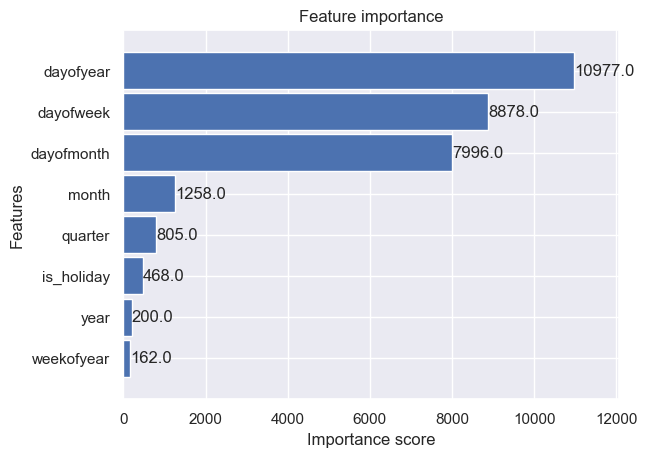

In [ ]:
#plot feature importance
# Plot feature importance
plot_importance(model, height=0.9)
plt.show()

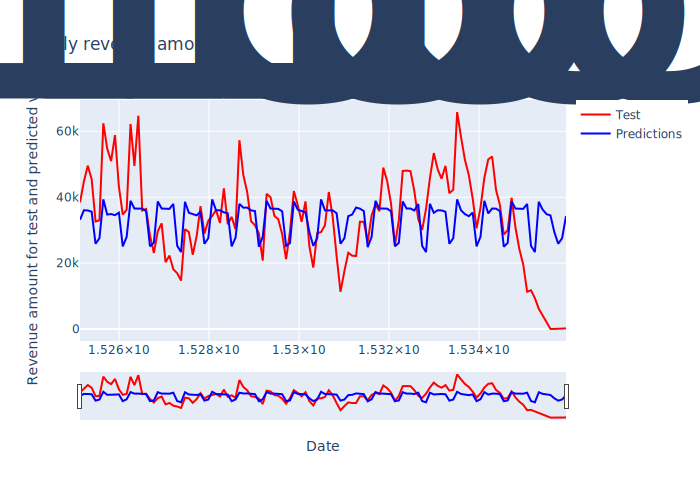

In [ ]:
#plotting test and predictions
plot_test_predictions(y_test_df['total_amount'], predictions_xgb_tuned)

#### Observations:

- After tuning, it is able to capture the peaks of within a week which occurs at the start of week. 
- The MAPE obtained is very good but I still less than the tuned FB Prophet.
- Also, since we have a limited data I am assuming that it is not learning enough. It could be tested further on more data.

# 7. Modelling (LSTM)

<a id = "LSTM"></a>


We can use univariate LSTM to predict the next value in out time series. We will use only one step prediction, meaning we will use only one previous observation to predict the next value.

Like previous models of SARIMA and XG Boost, LSTM also takes the input in certain format. It takes a series of data with number of observations X number of timesteps X number of features.

## 7.1 Preparing data for LSTM

<a id ="lstm_prep"></a>

We need to scale the data in order to apply it to LSTM

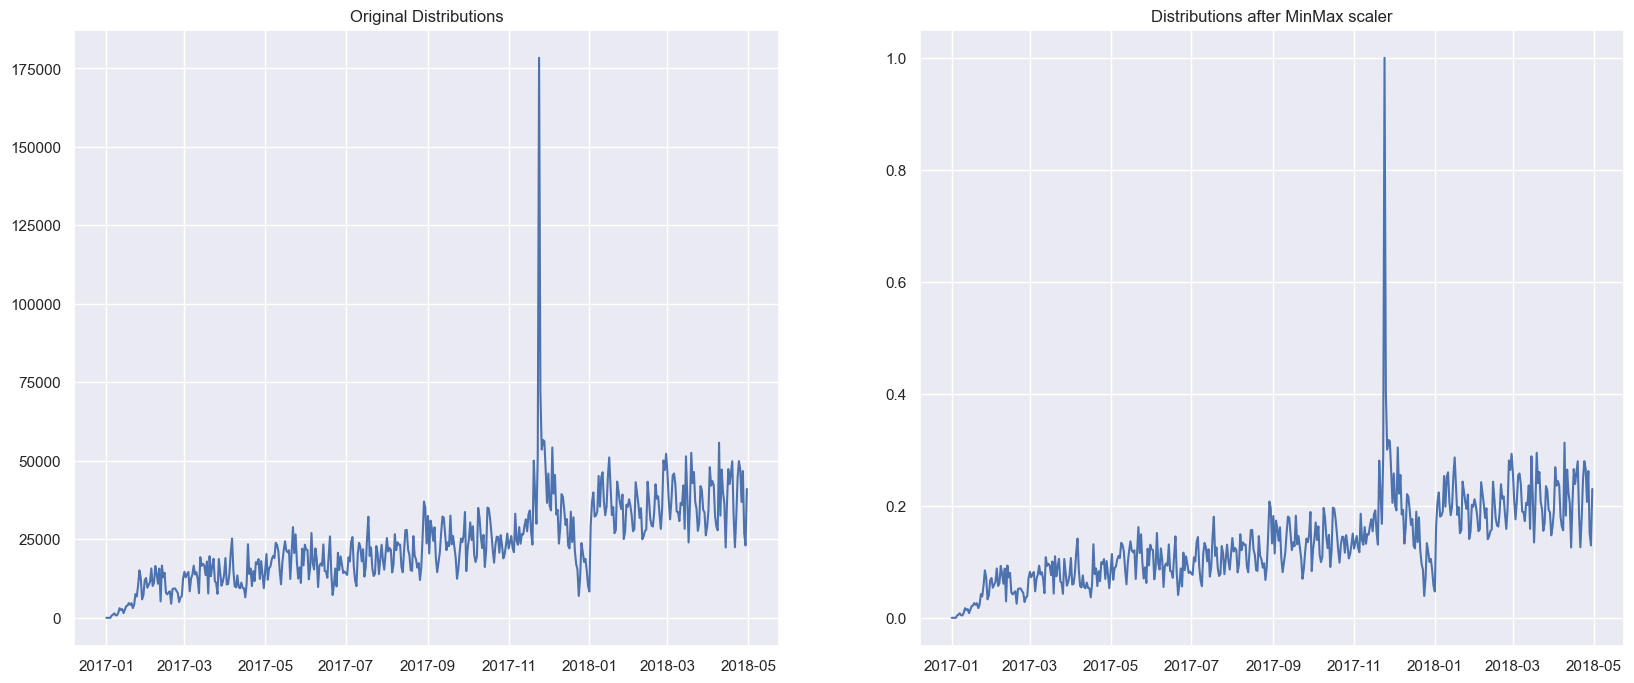

In [ ]:
#scaling the date
sc = MinMaxScaler(feature_range = (0,1))
training_scaled = sc.fit_transform(train_df)
test_scaled = sc.transform(test_df)
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax0.set_title('Original Distributions')
ax1.set_title('Distributions after MinMax scaler')
ax0.plot(train_df['total_amount'])
ax1.plot(pd.DataFrame(training_scaled,columns=['total_amount'], index=train_df.index)['total_amount'])

In [ ]:
# Define the lookback funtion for creating y

def lookback(df, window):
    X = list()
    Y = list()
    
    for i in range(window, len(df)):
        X.append(df[i-window:i, 0])
        Y.append(df[i,0])
    
    X,Y = np.array(X), np.array(Y)
    return X, Y

In [ ]:
# Creating X and Y using lookback function
X_train_lstm, y_train_lstm = lookback(training_scaled, 1)
X_test_lstm, y_test_lstm = lookback(test_scaled, 1)

In [ ]:
print("First 10 values of y_test_lstm:", y_test_lstm[:10])
print("Min value:", y_test_lstm.min())
print("Max value:", y_test_lstm.max())


First 10 values of y_test_lstm: [0.25095254 0.27792566 0.25504375 0.18280403 0.18496843 0.35015719
 0.30676543 0.28573448 0.33004077 0.24246319]
Min value: 0.0
Max value: 0.3692190551023691


In [ ]:
# Kiểm tra y_test_lstm
print("First 10 values of y_test_lstm:", y_test_lstm[:10])
print("Min value:", y_test_lstm.min())
print("Max value:", y_test_lstm.max())


First 10 values of y_test_lstm: [0.25095254 0.27792566 0.25504375 0.18280403 0.18496843 0.35015719
 0.30676543 0.28573448 0.33004077 0.24246319]
Min value: 0.0
Max value: 0.3692190551023691


In [ ]:
X_train_lstm

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00396502],
       [0.00554038],
       [0.00811755],
       [0.00453885],
       [0.00434197],
       [0.00880811],
       [0.01716768],
       [0.01403029],
       [0.01558895],
       [0.00840672],
       [0.01430303],
       [0.0207896 ],
       [0.02182791],
       [0.02625542],
       [0.02321009],
       [0.02610221],
       [0.01734954],
       [0.02321967],
       [0.04234774],
       [0.03802904],
       [0.05796809],
       [0.08471707],
       [0.07151205],
       [0.03298065],
       [0.04014326],
       [0.06670192],
       [0.07112742],
       [0.05365297],
       [0.05872541],
       [0.06405506],
       [0.088112  ],
       [0.05691992],
       [0.06214232],
       [0.09263611],
       [0.07863621],
       [0.06079333],
       [0.08783613],
       [0.02933748],
       [0.09332073],
       [0.07223927],
       [0.08040806],
       [0.04502538],
       [0.04179493],
       [0.045

In [ ]:
# checking shape of X
X_train_lstm.shape

(484, 1)

In [ ]:
# Reshape X for LSTM
# number of observations, timesteps and features
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1],1))
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1],1))

In [ ]:
X_train_lstm.shape

(484, 1, 1)

In [ ]:
X_test_lstm.shape

(125, 1, 1)

## 7.2 Baseline model on daily data and its performance

<a id ="lstm_baseline_eval"></a>

Let us apply the LSTM model with three layers. The starting layer has 100 nodes, second layer has 50 nodes and outut layer has 1 node. We will be using Keras Early stopping function to prevent it from overfitting. We have also chosen the batch size equal to 1

In [ ]:
# random seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

model = Sequential()

# 1️⃣ LSTM layer 1
model.add(LSTM(128, return_sequences=True, activation='relu',
               input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))

# 2️⃣ LSTM layer 2
model.add(LSTM(100, return_sequences=True, activation='relu'))

# 3️⃣ LSTM layer 3 (final)
model.add(LSTM(50, activation='relu'))

# 4️⃣ Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# 5️⃣ Output layer
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=16,
    shuffle=False,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            91600     
                                                                 
 lstm_2 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 193737 (756.79 KB)
Trainable params: 19373

In [ ]:
# prediction
y_pred = model.predict(X_test_lstm)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
r2 = r2_score(y_test_lstm, y_pred_lstm)

print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)



4/4 [==============================] - 0s 4ms/step
Accuracy (1 - MAPE): -6625118050582.21


In [ ]:
# Calculating predictions
prediction_lstm = model.predict(X_test_lstm)
prediction_lstm

4/4 [==============================] - 0s 3ms/step


array([[0.22888467],
       [0.24811065],
       [0.26100838],
       [0.25035417],
       [0.21109025],
       [0.2124703 ],
       [0.29380783],
       [0.27395535],
       [0.26449457],
       [0.28454736],
       [0.24347156],
       [0.2176851 ],
       [0.22216481],
       [0.29321262],
       [0.2608343 ],
       [0.29962298],
       [0.22146067],
       [0.22284533],
       [0.19412553],
       [0.16839105],
       [0.20063046],
       [0.20917195],
       [0.15281594],
       [0.16443984],
       [0.1390436 ],
       [0.13096257],
       [0.11666581],
       [0.20289358],
       [0.19962695],
       [0.16567746],
       [0.19331902],
       [0.22540094],
       [0.1971946 ],
       [0.21202567],
       [0.21652192],
       [0.22186413],
       [0.20955111],
       [0.2417199 ],
       [0.20819719],
       [0.21564098],
       [0.20283437],
       [0.28055575],
       [0.2540108 ],
       [0.23840082],
       [0.21144417],
       [0.20713446],
       [0.1974923 ],
       [0.155


#### Predictions and Evaluation using LSTM


In [ ]:
#predicting and inversing the predictions to original time scale.

prediction_inverse = sc.inverse_transform(prediction_lstm.reshape(-1, 1))
y_test_inverse = sc.inverse_transform(y_test_lstm.reshape(-1, 1))

prediction2_inverse = np.array(prediction_inverse[:,0][1:])
y_test2_inverse = np.array(y_test_inverse[:,0])

In [ ]:
#Evaluating the LSTM model.

y_test2_inverse_without_last = y_test2_inverse[:-1]
rmse_lstm = rmse_metrics(y_test2_inverse_without_last, prediction2_inverse)
mape_lstm = mape_metrics(y_test2_inverse_without_last, prediction2_inverse)
print(f"Root Mean Squared Error | RMSE: {rmse_lstm}")
print(f"Mean Absolute Percentage Error | MAPE: {mape_lstm}")

Root Mean Squared Error | RMSE: 5353.74
Mean Absolute Percentage Error | MAPE: inf


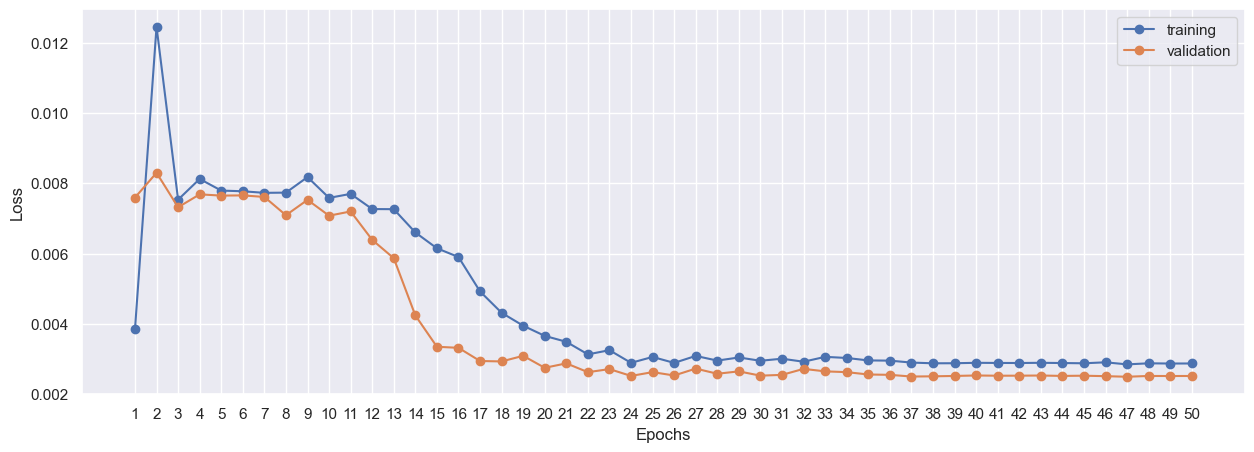

In [ ]:
# Plotting performance of the model

epochs = range(1, 51)

plt.figure(figsize=(15,5))
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label = "validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

Looking at the training metrics, we see that the validation and training loss decrease in parallel (so we are not overfitting):

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

#### Plotting the Test and Prediction Values

In [ ]:
test_df[: -2].index
y_test2_inverse_without_last=pd.DataFrame(y_test2_inverse_without_last, 
                                          columns=['total_amount'], 
                                          index= test_df[: -2].index)

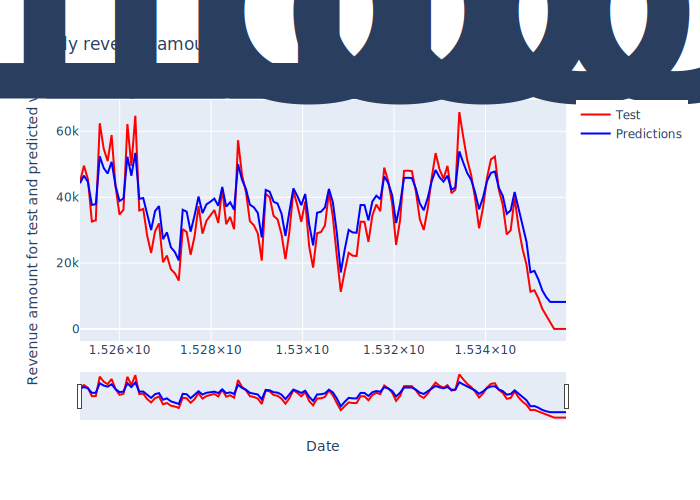

In [ ]:
plot_test_predictions(y_test2_inverse_without_last['total_amount'], prediction2_inverse)

`Note:` We have applied only one step time series forecasting which predicts the observation at the next time step.

Although we are getting very good result but still I am reluctant to proceed ahead with this model because we have limited sales data. We need to test it on more data to see how it performs.

Here is the summary of all the modela we tested:
    
 ### Summary:

| Model                              | MAPE  |
|------------------------------------|-------|
| SARIMA(1,1,1)(0,1,1)(7)           | 68.99 |
| SARIMAX(1,1,2)(0,1,1)(7) Including impact of holidays | 65.66 |
| XGBoost Regression including Holiday | 52.18 |
| Tuned XGBoost Regression including Holiday | 47.58 |
| <span style="color:blue">LSTM (one step Prediction)</span> | <span style="color:blue">13.39</span> |


In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for each model
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train",line=dict(color='blue'), hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test",line=dict(color='black'), hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index, y=sarimax_predictions.values, mode='lines', name="SARIMAX", hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index, y=predictions_xgb_tuned, mode='lines', name="XGB Tuned", hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index[: -2], y=prediction2_inverse, mode='lines', name="LSTM",line=dict(color='red'), hoverinfo='x+y+name'))

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", rangeslider_visible=True)
fig.update_yaxes(title_text="Revenue amount")

# Update layout
fig.update_layout(
    title="Daily Sales amount and forecast using different models",
    yaxis_title="Revenue amount",
    xaxis_title="Date",
)

# Show plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add traces for each model
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test",line=dict(color='blue'), hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index, y=sarimax_predictions.values, mode='lines', name="SARIMAX",line=dict(color='lightblue'), hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index, y=predictions_xgb_tuned, mode='lines', name="XGB Tuned", hoverinfo='x+y+name'))
fig.add_trace(go.Scatter(x=test_df.index[: -2], y=prediction2_inverse, mode='lines', name="LSTM",line=dict(color='red'), hoverinfo='x+y+name'))

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", rangeslider_visible=True)
fig.update_yaxes(title_text="Revenue amount")

# Update layout
fig.update_layout(
    title="Daily Sales amount and forecast using different models",
    yaxis_title="Revenue amount",
    xaxis_title="Date",
)

# Show plot
fig.show()


In [ ]:
test_df.index[: -2]

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08',
               '2018-05-09', '2018-05-10',
               ...
               '2018-08-23', '2018-08-24', '2018-08-25', '2018-08-26',
               '2018-08-27', '2018-08-28', '2018-08-29', '2018-08-30',
               '2018-08-31', '2018-09-01'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=124, freq='D')

In [ ]:
test_df.index

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08',
               '2018-05-09', '2018-05-10',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=126, freq='D')

In [ ]:
prediction2_inverse

array([43004.215 , 44699.367 , 43260.59  , 38040.55  , 38308.504 ,
       49341.63  , 46566.848 , 45198.145 , 48072.496 , 42467.152 ,
       39208.63  , 39862.56  , 49269.715 , 44674.527 , 49947.156 ,
       39758.77  , 39954.566 , 34679.13  , 29716.39  , 35724.793 ,
       37614.363 , 26089.21  , 28733.547 , 23329.775 , 21756.021 ,
       18945.115 , 36224.156 , 35541.37  , 29057.227 , 34552.95  ,
       40282.594 , 35159.83  , 38238.96  , 39040.188 , 39818.23  ,
       37698.54  , 42265.035 , 37398.05  , 38892.113 , 36211.074 ,
       47504.32  , 43705.2   , 41884.47  , 38119.258 , 37162.41  ,
       35206.496 , 26729.27  , 41689.777 , 41342.43  , 39041.875 ,
       38480.87  , 35014.844 , 27292.785 , 35594.305 , 41986.125 ,
       40411.492 , 37959.387 , 40846.645 , 32114.285 , 23955.873 ,
       35253.59  , 35534.99  , 37127.582 , 41882.1   , 38844.645 ,
       28514.26  , 15620.971 , 22578.852 , 29759.438 , 28696.678 ,
       28556.451 , 38010.023 , 37978.023 , 33223.24  , 39111.2

In [ ]:
test_df.index

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08',
               '2018-05-09', '2018-05-10',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=126, freq='D')

In [ ]:
# Assuming prediction2_inverse is a pandas Series or list
prediction = pd.Series(prediction2_inverse)  # Convert to Series if not already

# Convert prediction2_inverse to DataFrame
predicted = pd.DataFrame({'predicted': prediction})


In [ ]:
prediction2_inverse

array([43004.215 , 44699.367 , 43260.59  , 38040.55  , 38308.504 ,
       49341.63  , 46566.848 , 45198.145 , 48072.496 , 42467.152 ,
       39208.63  , 39862.56  , 49269.715 , 44674.527 , 49947.156 ,
       39758.77  , 39954.566 , 34679.13  , 29716.39  , 35724.793 ,
       37614.363 , 26089.21  , 28733.547 , 23329.775 , 21756.021 ,
       18945.115 , 36224.156 , 35541.37  , 29057.227 , 34552.95  ,
       40282.594 , 35159.83  , 38238.96  , 39040.188 , 39818.23  ,
       37698.54  , 42265.035 , 37398.05  , 38892.113 , 36211.074 ,
       47504.32  , 43705.2   , 41884.47  , 38119.258 , 37162.41  ,
       35206.496 , 26729.27  , 41689.777 , 41342.43  , 39041.875 ,
       38480.87  , 35014.844 , 27292.785 , 35594.305 , 41986.125 ,
       40411.492 , 37959.387 , 40846.645 , 32114.285 , 23955.873 ,
       35253.59  , 35534.99  , 37127.582 , 41882.1   , 38844.645 ,
       28514.26  , 15620.971 , 22578.852 , 29759.438 , 28696.678 ,
       28556.451 , 38010.023 , 37978.023 , 33223.24  , 39111.2

In [ ]:
prediction

0      43004.214844
1      44699.367188
2      43260.589844
3      38040.550781
4      38308.503906
           ...     
119    15105.543945
120    15103.479492
121    15103.479492
122    15103.479492
123    15103.479492
Length: 124, dtype: float32

In [ ]:
predicted

,predicted
0,43004.214844
1,44699.367188
2,43260.589844
3,38040.550781
4,38308.503906
...,...
119,15105.543945
120,15103.479492
121,15103.479492
122,15103.479492


In [ ]:
modified_test_df = test_df.iloc[:-2]  # Exclude last 2 rows
modified_test_df['predicted'] = predicted.values

In [ ]:
actual_value = test_df.iloc[:-2]
actual_value

,total_amount
order_purchase_timestamp,
2018-05-01,38441.68
2018-05-02,44764.32
2018-05-03,49575.72
2018-05-04,45494.10
2018-05-05,32608.15
...,...
2018-08-28,4121.22
2018-08-29,1762.70
2018-08-30,0.00


In [ ]:
actual_value.to_csv("actual_value.csv", index=False)

In [ ]:
predicted.to_csv("Forecast_value.csv", index=False)

In [ ]:
modified_test_df

,total_amount,predicted
order_purchase_timestamp,,
2018-05-01,38441.68,43004.214844
2018-05-02,44764.32,44699.367188
2018-05-03,49575.72,43260.589844
2018-05-04,45494.10,38040.550781
2018-05-05,32608.15,38308.503906
...,...,...
2018-08-28,4121.22,15105.543945
2018-08-29,1762.70,15103.479492
2018-08-30,0.00,15103.479492


In [ ]:
modified_test_df.to_csv("forecast_actual.csv", index=False)

In [ ]:
if 'predicted' in test_df.columns:
    test_df.drop('predicted', axis=1, inplace=True)



In [ ]:
test_df.dropna(inplace=True)

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming your data is daily, you can extend the index by 6 years (6 * 365 days)
extended_index = pd.date_range(start=test_df.index[-1], periods=180)

# Create subplots with 3 rows and 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=("SARIMAX", "XGB Tuned", "LSTM"))

# Add traces for SARIMAX
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train"), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test"), row=1, col=1)
fig.add_trace(go.Scatter(x=extended_index, y=sarimax_predictions.values, mode='lines', name="SARIMAX"), row=1, col=1)

# Add traces for XGB Tuned
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train"), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test"), row=2, col=1)
fig.add_trace(go.Scatter(x=extended_index, y=predictions_xgb_tuned, mode='lines', name="XGB Tuned"), row=2, col=1)

# Add traces for LSTM
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train",line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test", line=dict(color='black')), row=3, col=1)
fig.add_trace(go.Scatter(x=extended_index[: -2], y=prediction2_inverse, mode='lines', name="LSTM", line=dict(color='red')), row=3, col=1)



# Update layout
fig.update_layout(
    height=1000,
    width=800,
    title="Daily Sales amount and forecast using different models",
    showlegend=True
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Revenue amount", row=2, col=1)

# Show plot
fig.show()


In [ ]:
# Actual Sales 
y_test2_inverse_without_last

,total_amount
order_purchase_timestamp,
2018-05-01,44764.32
2018-05-02,49575.72
2018-05-03,45494.10
2018-05-04,32608.15
2018-05-05,32994.23
...,...
2018-08-28,1762.70
2018-08-29,0.00
2018-08-30,0.00


In [ ]:
prediction2_inverse

array([43004.215 , 44699.367 , 43260.59  , 38040.55  , 38308.504 ,
       49341.63  , 46566.848 , 45198.145 , 48072.496 , 42467.152 ,
       39208.63  , 39862.56  , 49269.715 , 44674.527 , 49947.156 ,
       39758.77  , 39954.566 , 34679.13  , 29716.39  , 35724.793 ,
       37614.363 , 26089.21  , 28733.547 , 23329.775 , 21756.021 ,
       18945.115 , 36224.156 , 35541.37  , 29057.227 , 34552.95  ,
       40282.594 , 35159.83  , 38238.96  , 39040.188 , 39818.23  ,
       37698.54  , 42265.035 , 37398.05  , 38892.113 , 36211.074 ,
       47504.32  , 43705.2   , 41884.47  , 38119.258 , 37162.41  ,
       35206.496 , 26729.27  , 41689.777 , 41342.43  , 39041.875 ,
       38480.87  , 35014.844 , 27292.785 , 35594.305 , 41986.125 ,
       40411.492 , 37959.387 , 40846.645 , 32114.285 , 23955.873 ,
       35253.59  , 35534.99  , 37127.582 , 41882.1   , 38844.645 ,
       28514.26  , 15620.971 , 22578.852 , 29759.438 , 28696.678 ,
       28556.451 , 38010.023 , 37978.023 , 33223.24  , 39111.2

In [ ]:
# Assuming your data is daily, you can extend the index by 180 days
extended_index = pd.date_range(start=test_df.index[-1], periods=180)

# Create figure
fig = make_subplots(rows=3, cols=1)

# Add traces for LSTM
fig.add_trace(go.Scatter(
    x=train_df.index, 
    y=train_df['total_amount'].values, 
    mode='lines', 
    name="Train",
    line=dict(color='blue')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=test_df.index, 
    y=test_df['total_amount'].values, 
    mode='lines', 
    name="Test", 
    line=dict(color='black')
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=extended_index[:-2], 
    y=prediction2_inverse, 
    mode='lines', 
    name="LSTM", 
    line=dict(color='red')
), row=3, col=1)

# Update layout
fig.update_layout(
    height=1000,
    width=1000,
    title="Daily Sales amount and forecast using LSTM model for the next 3 months",
    showlegend=True
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Revenue amount", row=2, col=1)

# Show plot
fig.show()


In [ ]:
daily_data

,total_amount
order_purchase_timestamp,
2017-01-01,0.00
2017-01-02,0.00
2017-01-03,0.00
2017-01-04,0.00
2017-01-05,707.27
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with 3 rows and 1 column
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                    subplot_titles=("SARIMAX", "XGB Tuned", "LSTM"))

# Add traces for SARIMAX
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train"), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test"), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=sarimax_predictions.values, mode='lines', name="SARIMAX"), row=1, col=1)

# Add traces for XGB Tuned
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train"), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test"), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=predictions_xgb_tuned, mode='lines', name="XGB Tuned"), row=2, col=1)

# Add traces for LSTM
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train"), row=3, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test",line=dict(color='red')), row=3, col=1)
fig.add_trace(go.Scatter(x=test_df.index[: -2], y=prediction2_inverse, mode='lines', name="LSTM", line=dict(color='blue')), row=3, col=1)

# Update layout
fig.update_layout(
    
    height=1000,
    width=800,
    title="Daily Sales amount and forecast using different models",
    showlegend=True
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", row=3, col=1)
fig.update_yaxes(title_text="Revenue amount", row=2, col=1)

# Show plot
fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot with 1 row and 1 column
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=("LSTM Model"))

# Add traces for LSTM
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['total_amount'].values, mode='lines', name="Train", line=dict(color='purple')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['total_amount'].values, mode='lines', name="Test", line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=prediction2_inverse, mode='lines', name="LSTM", line=dict(color='red')), row=1, col=1)

# Update layout
fig.update_layout(
    height=500,
    width=800,
    title="Daily Sales amount and forecast using LSTM",
    showlegend=True
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Revenue amount", row=1, col=1)

# Show plot
fig.show()


In [ ]:
train_df.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24',
               '2018-04-25', '2018-04-26', '2018-04-27', '2018-04-28',
               '2018-04-29', '2018-04-30'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=485, freq='D')

In [ ]:
test_df.index

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08',
               '2018-05-09', '2018-05-10',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=126, freq='D')

In [ ]:
test_df['total_amount']

order_purchase_timestamp
2018-05-01    38441.68
2018-05-02    44764.32
2018-05-03    49575.72
2018-05-04    45494.10
2018-05-05    32608.15
                ...   
2018-08-30        0.00
2018-08-31        0.00
2018-09-01        0.00
2018-09-02        0.00
2018-09-03      166.46
Freq: D, Name: total_amount, Length: 126, dtype: float64

In [ ]:
test_df.index[:-2]

DatetimeIndex(['2018-05-01', '2018-05-02', '2018-05-03', '2018-05-04',
               '2018-05-05', '2018-05-06', '2018-05-07', '2018-05-08',
               '2018-05-09', '2018-05-10',
               ...
               '2018-08-23', '2018-08-24', '2018-08-25', '2018-08-26',
               '2018-08-27', '2018-08-28', '2018-08-29', '2018-08-30',
               '2018-08-31', '2018-09-01'],
              dtype='datetime64[ns]', name='order_purchase_timestamp', length=124, freq='D')

In [ ]:
test_df

,total_amount
order_purchase_timestamp,
2018-05-01,38441.68
2018-05-02,44764.32
2018-05-03,49575.72
2018-05-04,45494.10
2018-05-05,32608.15
...,...
2018-08-30,0.00
2018-08-31,0.00
2018-09-01,0.00


In [ ]:
prediction2_inverse.tolist()

[43004.21484375,
 44699.3671875,
 43260.58984375,
 38040.55078125,
 38308.50390625,
 49341.62890625,
 46566.84765625,
 45198.14453125,
 48072.49609375,
 42467.15234375,
 39208.62890625,
 39862.55859375,
 49269.71484375,
 44674.52734375,
 49947.15625,
 39758.76953125,
 39954.56640625,
 34679.12890625,
 29716.390625,
 35724.79296875,
 37614.36328125,
 26089.2109375,
 28733.546875,
 23329.775390625,
 21756.021484375,
 18945.115234375,
 36224.15625,
 35541.37109375,
 29057.2265625,
 34552.94921875,
 40282.59375,
 35159.828125,
 38238.9609375,
 39040.1875,
 39818.23046875,
 37698.5390625,
 42265.03515625,
 37398.05078125,
 38892.11328125,
 36211.07421875,
 47504.3203125,
 43705.19921875,
 41884.46875,
 38119.2578125,
 37162.41015625,
 35206.49609375,
 26729.26953125,
 41689.77734375,
 41342.4296875,
 39041.875,
 38480.87109375,
 35014.84375,
 27292.78515625,
 35594.3046875,
 41986.125,
 40411.4921875,
 37959.38671875,
 40846.64453125,
 32114.28515625,
 23955.873046875,
 35253.58984375,
 355

In [ ]:
test_df.index.tolist()

[Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-05-02 00:00:00'),
 Timestamp('2018-05-03 00:00:00'),
 Timestamp('2018-05-04 00:00:00'),
 Timestamp('2018-05-05 00:00:00'),
 Timestamp('2018-05-06 00:00:00'),
 Timestamp('2018-05-07 00:00:00'),
 Timestamp('2018-05-08 00:00:00'),
 Timestamp('2018-05-09 00:00:00'),
 Timestamp('2018-05-10 00:00:00'),
 Timestamp('2018-05-11 00:00:00'),
 Timestamp('2018-05-12 00:00:00'),
 Timestamp('2018-05-13 00:00:00'),
 Timestamp('2018-05-14 00:00:00'),
 Timestamp('2018-05-15 00:00:00'),
 Timestamp('2018-05-16 00:00:00'),
 Timestamp('2018-05-17 00:00:00'),
 Timestamp('2018-05-18 00:00:00'),
 Timestamp('2018-05-19 00:00:00'),
 Timestamp('2018-05-20 00:00:00'),
 Timestamp('2018-05-21 00:00:00'),
 Timestamp('2018-05-22 00:00:00'),
 Timestamp('2018-05-23 00:00:00'),
 Timestamp('2018-05-24 00:00:00'),
 Timestamp('2018-05-25 00:00:00'),
 Timestamp('2018-05-26 00:00:00'),
 Timestamp('2018-05-27 00:00:00'),
 Timestamp('2018-05-28 00:00:00'),
 Timestamp('2018-05-

In [ ]:
# get the index as a list
test_df_index = test_df.index.tolist()

# check lengths of both
print(len(test_df_index))
print(len(prediction2_inverse))


126
124


In [ ]:
test_df_index = test_df.index.tolist()

# if prediction2_inverse is numpy array
prediction2_inverse = prediction2_inverse.tolist()

# make sure both lists have the same length
min_len = min(len(test_df_index), len(prediction2_inverse))
data = {
    'x': test_df_index[:min_len],
    'y': prediction2_inverse[:min_len]
}

df = pd.DataFrame(data)
print(df)


             x             y
0   2018-05-01  43004.214844
1   2018-05-02  44699.367188
2   2018-05-03  43260.589844
3   2018-05-04  38040.550781
4   2018-05-05  38308.503906
..         ...           ...
119 2018-08-28  15105.543945
120 2018-08-29  15103.479492
121 2018-08-30  15103.479492
122 2018-08-31  15103.479492
123 2018-09-01  15103.479492

[124 rows x 2 columns]


In [ ]:
y_test2_inverse_without_last

,total_amount
order_purchase_timestamp,
2018-05-01,44764.32
2018-05-02,49575.72
2018-05-03,45494.10
2018-05-04,32608.15
2018-05-05,32994.23
...,...
2018-08-28,1762.70
2018-08-29,0.00
2018-08-30,0.00


In [ ]:
import joblib
model.save('lstm_model.h5')  # Save the LSTM model
joblib.dump(sc, 'scaler.pkl')  # Save the MinMaxScaler instance


['scaler.pkl']